# Applying All Districts & Provincial Triggers (Dual Pathway Refactor)

This refactored notebook processes activations in **two parallel ways from the beginning**:
- **District-level activations**: based on the number of districts crossing thresholds, aggregated to provinces (`district_trigger`).
- **Provincial-level activations**: based on provincial totals crossing thresholds (`provincial_trigger`).

Both columns are carried through the entire workflow, and all outputs (tables, heatmaps, timelines, return periods, and spending estimates) now distinguish between **district-level** (orange) and **provincial-level** (red) activations.

Special handling:
- **Maputo Cidade**: Only has provincial activations and thus appears exclusively via `provincial_trigger`.


# Applying All Districts Analysis

This notebook processes rainfall/drought data at the district level. It covers:
- Data Loading
- Preprocessing
- Analysis
- Visualization
- Results Export


# Applying the trigger logic to all districts


## 1. Setup & Imports
Load required libraries and set global parameters.

## Updates in this Refactored Notebook
- **Refactored code**: Cleaned and modularized without changing outputs.
- **Maputo Cidade handling**: Treated as provincial-only (not district-based). Always included in summary tables and plots.
- **District vs Provincial activations**: Both levels shown side by side in tables and timelines for comparison.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

## 2. Data Loading
Read in rainfall and drought datasets for all districts.

In [2]:
# Data and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from pathlib import Path
from matplotlib.patches import Rectangle
import calendar

import os
import re
import rasterio
import geopandas as gpd
import rasterstats as rs
from fuzzywuzzy import process
from unidecode import unidecode
from scipy.stats.mstats import winsorize
from src.constants import *
from src.utils import *

# Display settings
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.1f}".format
sns.set(style="whitegrid")

In [3]:
# load admin boundaries
adm2_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)
gdf_adm2 = gpd.read_file(adm2_path)

In [4]:
district_df = pd.read_csv(
    Path(os.getenv("AA_DATA_DIR"))
    / "private"
    / "processed"
    / "moz"
    / "cholera"
    / "cholera_data_all_cleaned.csv"
)
# only keep those with week values
district_df = district_df[district_df["week"].notna()]

## 3. Preprocessing
Clean and structure the data (e.g., time parsing, merging, filtering).

In [5]:
# maputo city values are divided into different admin units which are not admin 3
# we should start by summing all values for maputo city
summed = (
    district_df[district_df["province"] == "Maputo Cidade"]
    .groupby(["year", "week"], as_index=False)
    .sum(numeric_only=True)
)
summed["province"] = "Maputo Cidade"
summed["district"] = "Maputo Cidade"
summed
df_rest = district_df[district_df["province"] != "Maputo Cidade"]
district_df = pd.concat([df_rest, summed], ignore_index=True)
district_df

province       district  year  week   cases
0       Cabo Delgado        Ancuabe  2017   1.0   104.0
1       Cabo Delgado        Ancuabe  2017   2.0   103.0
2       Cabo Delgado        Ancuabe  2017   3.0    81.0
3       Cabo Delgado        Ancuabe  2017   4.0    94.0
4       Cabo Delgado        Ancuabe  2017   5.0    84.0
...              ...            ...   ...   ...     ...
60895  Maputo Cidade  Maputo Cidade  2025  19.0   928.0
60896  Maputo Cidade  Maputo Cidade  2025  20.0 1,066.0
60897  Maputo Cidade  Maputo Cidade  2025  21.0 1,082.0
60898  Maputo Cidade  Maputo Cidade  2025  22.0 1,200.0
60899  Maputo Cidade  Maputo Cidade  2025  23.0   724.0

[60900 rows x 5 columns]

In [6]:
# testing out winsorization
winsorized_values = district_df.groupby(["province", "district"])[
    "cases"
].transform(
    lambda x: winsorize(
        x, limits=[winsorising_lower_limit, winsorising_upper_limit]
    )
)
district_df["cases_winsorized"] = winsorized_values

In [7]:
# using the 2025 file
gdf_adm2_pop = pd.read_csv(
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "worldpop"
    / "adm2_population_totals.csv"
)
gdf_adm2 = gdf_adm2.merge(
    gdf_adm2_pop,
    how="left",
    on="ADM2_PCODE",
    suffixes=("", "_pop"),
)

## 4. Analysis
Apply drought/rainfall calculations across all districts.

In [8]:
# it seems the admin bounds districts are not matching the cholera data ones
# trying some fuzzy matching to see if we can get a match


# add the population data to the gdf
pop_df = gdf_adm2[["ADM2_PT", "ADM1_PT", "sum_population"]].copy()
district_df.loc[:, "district_norm"] = district_df["district"].apply(normalize)
pop_df["ADM2_PT_norm"] = pop_df["ADM2_PT"].apply(normalize)
mapping = {}
for name in district_df["district_norm"]:
    result = process.extractOne(name, pop_df["ADM2_PT_norm"])
    if result:
        match, score = result[0], result[1]
    if score >= 80:
        match_row = pop_df[pop_df["ADM2_PT_norm"] == match].iloc[0]
        mapping[name] = match_row["ADM2_PT"]
district_df["matched_name"] = district_df["district_norm"].map(mapping)

In [9]:
# cidade de maputo is split into various smaller units
# inhassunge is labelled as inhass
# lago niassa is different from lago
manual_map = {
    "inhass": "Inhassunge",
}
for name in district_df["district_norm"]:
    if "maputo" in name and "city" in name:
        manual_map[name] = "Cidade de Maputo"
mapping.update(manual_map)
district_df["matched_name"] = district_df["district_norm"].map(mapping)

In [10]:
district_df["date"] = pd.to_datetime(
    district_df["year"].astype(str)
    + district_df["week"].astype(int).astype(str).str.zfill(2)
    + "1",
    format="%G%V%u",
)

## 5. Visualization
Plot comparisons and validation results.

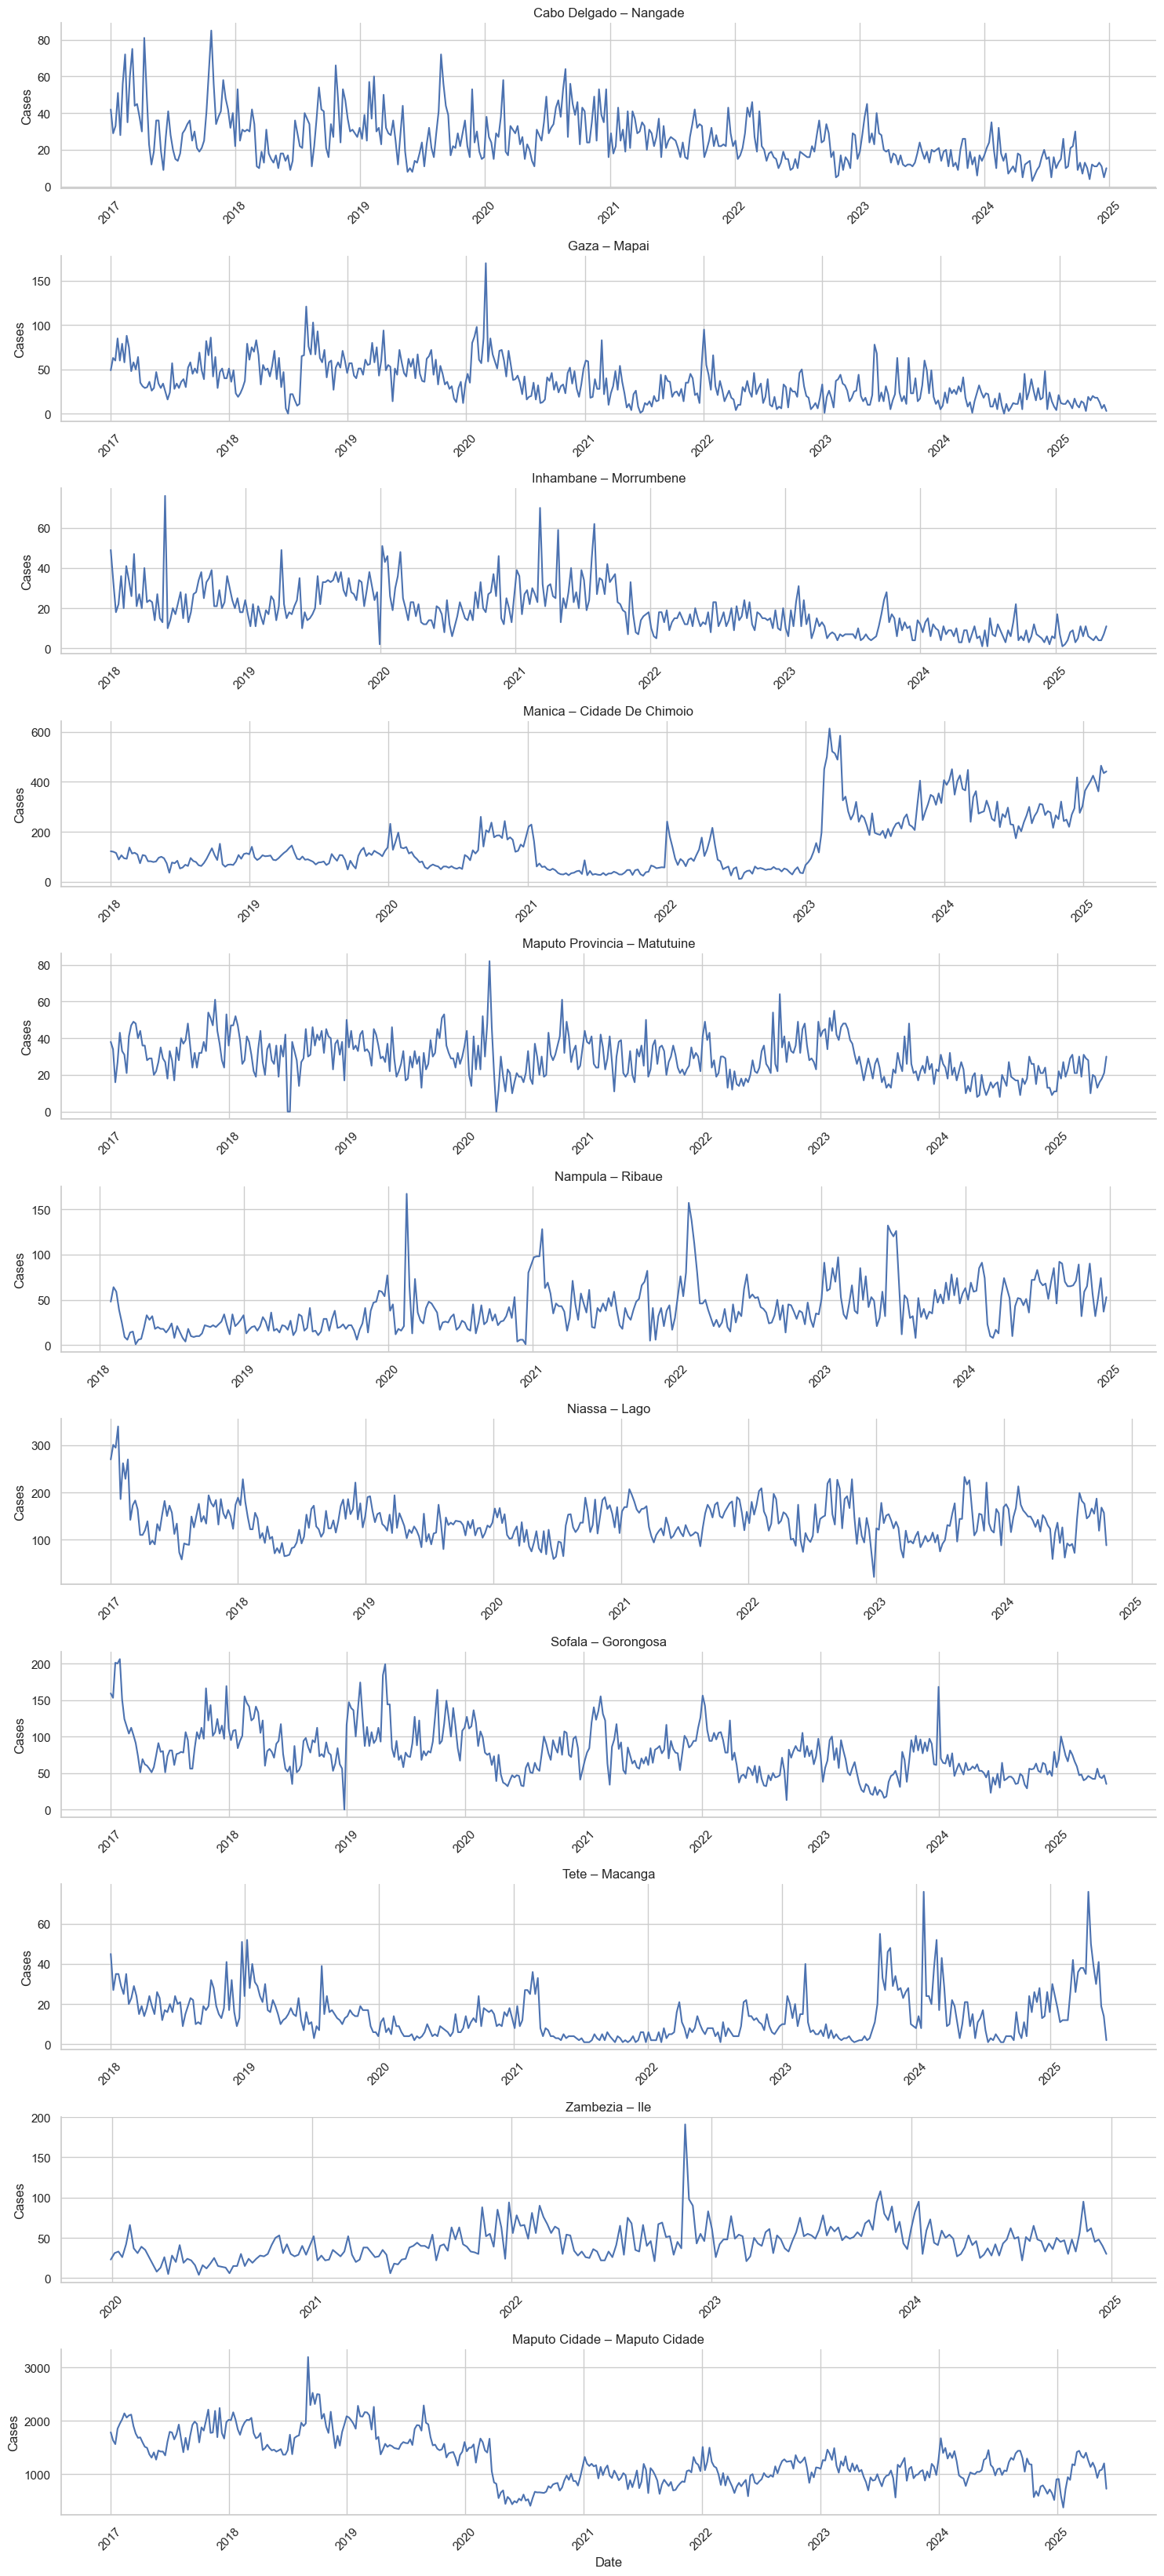

In [11]:
# Plot a random sample of one district per province
# to avoid too many plots, we will sample one district per province
selected_districts = (
    district_df.groupby("province")["district"]
    .apply(lambda x: x.sample(n=1, random_state=42).iloc[0])
    .tolist()
)
filtered_df = district_df[district_df["district"].isin(selected_districts)]
district_labels = filtered_df.groupby("province")["district"].first().to_dict()
g = sns.FacetGrid(
    filtered_df,
    row="province",
    sharex=False,
    sharey=False,
    height=3,
    aspect=5,
)
g.map_dataframe(sns.lineplot, x="date", y="cases_winsorized")

for ax in g.axes.flat:
    province = ax.get_title().replace("province = ", "")
    district = district_labels.get(province, "")
    ax.set_title(f"{province} – {district}")

g.set_axis_labels("Date", "Cases")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()

In [12]:
# Normalise the cholera data by population
district_pop_df = district_df.merge(
    pop_df, left_on="matched_name", right_on="ADM2_PT", how="left"
)

In [13]:
pop_df[pop_df["ADM2_PT"] == "Cidade De Maputo"]

ADM2_PT      ADM1_PT  sum_population      ADM2_PT_norm
30  Cidade De Maputo  Maputo City     1,018,559.4  cidade de maputo

## 6. Results Export
Save processed data and plots for external use.

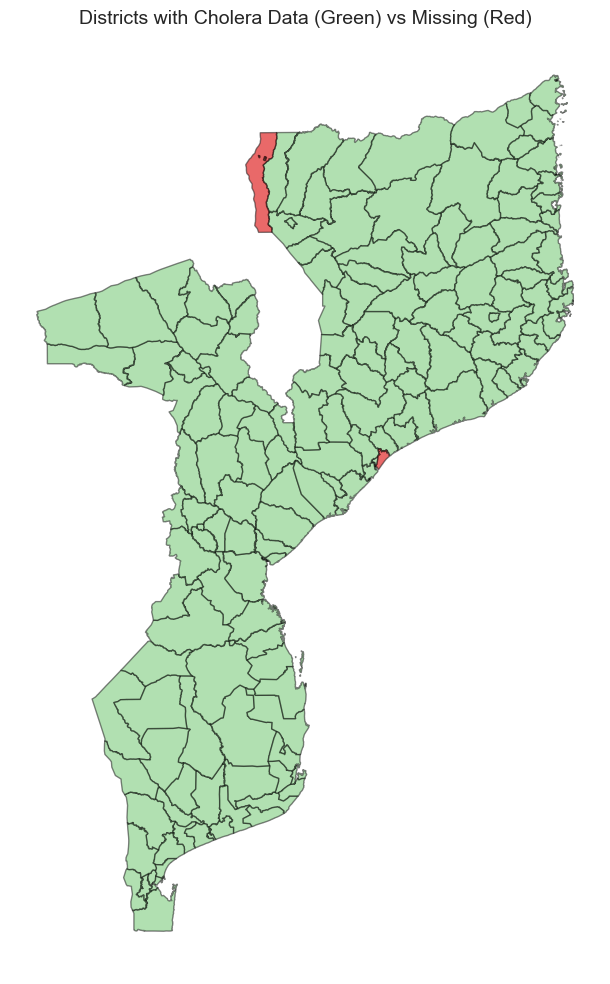

In [14]:
base = gdf_adm2.plot(color="lightgrey", edgecolor="white", figsize=(10, 10))

matched_districts = district_pop_df["ADM2_PT"].unique()
gdf_matched = gdf_adm2[gdf_adm2["ADM2_PT"].isin(matched_districts)]
gdf_matched.plot(ax=base, color="lightgreen", edgecolor="black", alpha=0.5)

gdf_missing = gdf_adm2[~gdf_adm2["ADM2_PT"].isin(matched_districts)]
gdf_missing.plot(ax=base, color="red", edgecolor="black", alpha=0.5)

plt.title("Districts with Cholera Data (Green) vs Missing (Red)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [15]:
# not all districts are in the cholera data
gdf_missing[["ADM2_PT", "ADM1_PT"]]

ADM2_PT   ADM1_PT
53     Ilha Licom    Niassa
54  Ilha Risunodo    Niassa
60    Lago Niassa    Niassa
85       Maquival  Zambezia

In [16]:
# check if merging is done well
# it should be empty if all the names are matched
district_pop_df[district_pop_df["ADM2_PT"].isna()][
    [
        "province",
        "district",
        "matched_name",
    ]
].drop_duplicates()

Empty DataFrame
Columns: [province, district, matched_name]
Index: []

## 7. Summary
Provide a concise overview of outputs and next steps.

In [17]:
# No district called Sofala

In [18]:
gdf_adm2[gdf_adm2["ADM1_PT"].isin(["Maputo City"])]

Shape_Leng  Shape_Area           ADM2_PT ADM2_PCODE ADM2_REF ADM2ALT1PT  \
30         1.8         0.0  Cidade De Maputo     MZ0601     None       None   

   ADM2ALT2PT      ADM1_PT ADM1_PCODE     ADM0_EN     ADM0_PT ADM0_PCODE  \
30       None  Maputo City       MZ06  Mozambique  Moçambique         MZ   

         date    validOn     validTo  \
30 2019-04-02 2019-06-07  0000/00/00   

                                             geometry  ADM1_PT_pop  \
30  MULTIPOLYGON (((32.99494 -25.97092, 32.99488 -...  Maputo City   

         ADM2_PT_pop  sum_population  
30  Cidade De Maputo     1,018,559.4

In [19]:
# now, normalise the cholera data by population
district_pop_df["cases_per_100k"] = (
    district_pop_df["cases_winsorized"] / district_pop_df["sum_population"]
) * 100000
district_pop_df["cases_per_100k"].describe()

count   57,800.0
mean        40.0
std         44.3
min          0.0
25%         10.8
50%         26.5
75%         54.2
max        892.1
Name: cases_per_100k, dtype: float64

In [20]:
district_pop_df[district_pop_df["cases_per_100k"] > 0]["cases_per_100k"]

0        45.7
1        45.3
2        35.6
3        41.3
4        36.9
         ... 
60895    91.1
60896   104.7
60897   106.2
60898   117.8
60899    71.1
Name: cases_per_100k, Length: 57254, dtype: float64

In [21]:
# check the distribution of the cases per 100k
# look at 99th percentile to set a trigger for each province OR 4x weekly increase in cases
country_level_percentile = (
    False  # if True, calculate percentiles at country level
)
if country_level_percentile:
    # Calculate 99th percentiles for the whole country
    percentiles = (
        district_pop_df[["province"]]
        .drop_duplicates()
        .assign(
            p99=district_pop_df.loc[
                district_pop_df["cases_per_100k"] > 0, "cases_per_100k"
            ].quantile(0.99)
        )
        .set_index("province")
    )
else:
    # Calculate percentiles per province
    percentiles = (
        district_pop_df[district_pop_df["cases_per_100k"] > 0]
        .groupby("province")["cases_per_100k"]
        .quantile([0.99])
        .unstack()
    )

# Merge percentiles back into the main df
district_df_with_percentiles = district_pop_df.merge(
    percentiles.rename(columns={0.99: "p99"}),
    left_on="province",
    right_index=True,
    how="left",
)
district_df_with_percentiles["weekly_pct_increase"] = (
    district_df_with_percentiles
    # group by district and calculate percentage change
    .groupby("district")["cases_per_100k"].pct_change(fill_method=None)
    * 100
)

In [22]:
# Check if cases cross the thresholds
district_df_with_percentiles["above_99th"] = (
    district_df_with_percentiles["cases_per_100k"]
    > district_df_with_percentiles["p99"]
)
district_df_with_percentiles["above_4x"] = (
    district_df_with_percentiles["weekly_pct_increase"] >= 300
)
district_df_with_percentiles["threshold_crossed"] = (
    district_df_with_percentiles["above_99th"]
    | district_df_with_percentiles["above_4x"]
)
district_df_with_percentiles = district_df_with_percentiles.sort_values(
    ["district", "year", "week"]
)
# also adding the condition of at least x cases for 3 consecutive weeks for a province
province_df = (
    district_df_with_percentiles.groupby(["province", "year", "week"])[
        "cases"
    ].sum()
).reset_index()
province_df["adm1_above_limit"] = province_df["cases"] >= province_case_limit
province_df = province_df.sort_values(["province", "year", "week"])
province_df["adm1_threshold_crossed"] = (
    province_df["adm1_above_limit"]
    & province_df.groupby("province")["adm1_above_limit"].shift(1)
    & province_df.groupby("province")["adm1_above_limit"].shift(2)
)
province_df[province_df["adm1_threshold_crossed"]]

province  year  week   cases  adm1_above_limit  adm1_threshold_crossed
3523   Sofala  2019  14.0 2,525.0              True                    True
3524   Sofala  2019  15.0 2,599.0              True                    True
3525   Sofala  2019  16.0 2,799.0              True                    True
3526   Sofala  2019  17.0 3,104.0              True                    True
3527   Sofala  2019  18.0 2,844.0              True                    True
3528   Sofala  2019  19.0 2,545.0              True                    True
3529   Sofala  2019  20.0 2,876.0              True                    True
3734   Sofala  2023  13.0 2,519.0              True                    True
4146     Tete  2023   6.0 2,674.0              True                    True

In [23]:
district_df_with_percentiles = district_df_with_percentiles.merge(
    province_df[
        [
            "province",
            "year",
            "week",
            "adm1_above_limit",
            "adm1_threshold_crossed",
        ]
    ],
    on=["province", "year", "week"],
    how="left",
)
district_df_with_percentiles[
    (district_df_with_percentiles["adm1_threshold_crossed"])
    & (district_df_with_percentiles["province"] == "Sofala")
]

province    district  year  week   cases  cases_winsorized  \
2395    Sofala       Beira  2019  14.0 1,097.0           1,097.0   
2396    Sofala       Beira  2019  15.0   979.0             979.0   
2397    Sofala       Beira  2019  16.0   975.0             975.0   
2398    Sofala       Beira  2019  17.0 1,144.0           1,144.0   
2399    Sofala       Beira  2019  18.0   848.0             848.0   
...        ...         ...   ...   ...     ...               ...   
54248   Sofala  Nhamatanda  2019  17.0   687.0             687.0   
54249   Sofala  Nhamatanda  2019  18.0   700.0             700.0   
54250   Sofala  Nhamatanda  2019  19.0   386.0             386.0   
54251   Sofala  Nhamatanda  2019  20.0   436.0             436.0   
54452   Sofala  Nhamatanda  2023  13.0   230.0             230.0   

      district_norm     matched_name       date          ADM2_PT ADM1_PT  \
2395          beira  Cidade Da Beira 2019-04-01  Cidade Da Beira  Sofala   
2396          beira  Cidade Da Beira 2019-04-08  Cidade Da Beira  Sofala   
2397          beira  Cidade Da Beira 2019-04-15  Cidade Da Beira  Sofala   
2398          beira  Cidade Da Beira 2019-04-22  Cidade Da Beira  Sofala   
2399          beira  Cidade Da Beira 2019-04-29  Cidade Da Beira  Sofala   
...             ...              ...        ...              ...     ...   
54248    nhamatanda       Nhamatanda 2019-04-22       Nhamatanda  Sofala   
54249    nhamatanda       Nhamatanda 2019-04-29       Nhamatanda  Sofala   
54250    nhamatanda       Nhamatanda 2019-05-06       Nhamatanda  Sofala   
54251    nhamatanda       Nhamatanda 2019-05-13       Nhamatanda  Sofala   
54452    nhamatanda       Nhamatanda 2023-03-27       Nhamatanda  Sofala   

       sum_population     ADM2_PT_norm  cases_per_100k   p99  \
2395        784,405.4  cidade da beira           139.9 150.1   
2396        784,405.4  cidade da beira           124.8 150.1   
2397        784,405.4  cidade da beira           124.3 150.1   
2398        784,405.4  cidade da beira           145.8 150.1   
2399        784,405.4  cidade da beira           108.1 150.1   
...               ...              ...             ...   ...   
54248       352,903.5       nhamatanda           194.7 150.1   
54249       352,903.5       nhamatanda           198.4 150.1   
54250       352,903.5       nhamatanda           109.4 150.1   
54251       352,903.5       nhamatanda           123.5 150.1   
54452       352,903.5       nhamatanda            65.2 150.1   

       weekly_pct_increase  above_99th  above_4x  threshold_crossed  \
2395                 -42.7       False     False              False   
2396                 -10.8       False     False              False   
2397                  -0.4       False     False              False   
2398                  17.3       False     False              False   
2399                 -25.9       False     False              False   
...                    ...         ...       ...                ...   
54248                 50.0        True     False               True   
54249                  1.9        True     False               True   
54250                -44.9       False     False              False   
54251                 13.0       False     False              False   
54452                 19.8       False     False              False   

       adm1_above_limit  adm1_threshold_crossed  
2395               True                    True  
2396               True                    True  
2397               True                    True  
2398               True                    True  
2399               True                    True  
...                 ...                     ...  
54248              True                    True  
54249              True                    True  
54250              True                    True  
54251              True                    True  
54452              True                    True  

[104 rows x 21 columns]

In [24]:
# Create the new column: True only if this week and the previous two weeks are above the 99th percentile or 4x increase
district_df_with_percentiles["district_consec_crossing"] = (
    district_df_with_percentiles["threshold_crossed"]
    & district_df_with_percentiles.groupby("district")[
        "threshold_crossed"
    ].shift(1)
    & district_df_with_percentiles.groupby("district")[
        "threshold_crossed"
    ].shift(2)
    & (
        (
            (district_df_with_percentiles["district"].isin(capital_districts))
            & (district_df_with_percentiles["cases"] >= capitals_threshold)
            & (
                district_df_with_percentiles["cases"].shift(1)
                >= capitals_threshold
            )
            & (
                district_df_with_percentiles["cases"].shift(2)
                >= capitals_threshold
            )
        )
        | (
            (~district_df_with_percentiles["district"].isin(capital_districts))
            & (district_df_with_percentiles["cases"] >= default_threshold)
            & (
                district_df_with_percentiles["cases"].shift(1)
                >= default_threshold
            )
            & (
                district_df_with_percentiles["cases"].shift(2)
                >= default_threshold
            )
        )
    )
)
district_df_with_percentiles["three_consec_crossing"] = (
    district_df_with_percentiles["district_consec_crossing"]
    | district_df_with_percentiles["adm1_threshold_crossed"]
)
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
][["province", "district"]].drop_duplicates()

province            district
1300               Tete             Angonia
2395             Sofala               Beira
3775             Sofala                Buzi
4391               Tete        Cahora Bassa
4659             Sofala                Caia
5275               Tete            Changara
5543             Sofala              Chemba
6011             Sofala          Cheringoma
6479             Sofala           Chibabava
8031               Tete            Chifunde
8698             Niassa          Chimbonila
9991               Tete              Chiuta
11347            Manica   Cidade De Chimoio
12586              Tete      Cidade De Tete
14139              Tete                 Doa
14407            Sofala               Dondo
16331            Sofala           Gorongosa
19412           Nampula  Ilha De Moçambique
21796           Nampula              Lalaua
25218              Tete             Macanga
25902            Sofala            Machanga
27491          Zambezia             Maganja
27972              Tete               Magoe
28211  Maputo Provincia              Magude
28770            Niassa              Majune
31625     Maputo Cidade       Maputo Cidade
32238              Tete              Marara
32654              Tete             Maravia
32807            Sofala            Maringue
36629            Niassa          Mavago (2)
42099              Tete             Moatize
45623            Sofala            Morromeu
47547            Sofala              Muanza
50345              Tete            Mutarara
50657           Nampula        Nacala-Porto
54245            Sofala          Nhamatanda
54765          Zambezia            Nicoadal
59085              Tete            Tsangano
60749              Tete               Zumbo

In [25]:
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
].head(5)

province district  year  week   cases  cases_winsorized district_norm  \
1300     Tete  Angonia  2023   6.0    97.0              97.0       angonia   
2395   Sofala    Beira  2019  14.0 1,097.0           1,097.0         beira   
2396   Sofala    Beira  2019  15.0   979.0             979.0         beira   
2397   Sofala    Beira  2019  16.0   975.0             975.0         beira   
2398   Sofala    Beira  2019  17.0 1,144.0           1,144.0         beira   

         matched_name       date          ADM2_PT ADM1_PT  sum_population  \
1300          Angonia 2023-02-06          Angonia    Tete       692,058.3   
2395  Cidade Da Beira 2019-04-01  Cidade Da Beira  Sofala       784,405.4   
2396  Cidade Da Beira 2019-04-08  Cidade Da Beira  Sofala       784,405.4   
2397  Cidade Da Beira 2019-04-15  Cidade Da Beira  Sofala       784,405.4   
2398  Cidade Da Beira 2019-04-22  Cidade Da Beira  Sofala       784,405.4   

         ADM2_PT_norm  cases_per_100k   p99  weekly_pct_increase  above_99th  \
1300          angonia            14.0 158.0                  9.0       False   
2395  cidade da beira           139.9 150.1                -42.7       False   
2396  cidade da beira           124.8 150.1                -10.8       False   
2397  cidade da beira           124.3 150.1                 -0.4       False   
2398  cidade da beira           145.8 150.1                 17.3       False   

      above_4x  threshold_crossed  adm1_above_limit  adm1_threshold_crossed  \
1300     False              False              True                    True   
2395     False              False              True                    True   
2396     False              False              True                    True   
2397     False              False              True                    True   
2398     False              False              True                    True   

      district_consec_crossing  three_consec_crossing  
1300                     False                   True  
2395                     False                   True  
2396                     False                   True  
2397                     False                   True  
2398                     False                   True

In [26]:
# Compute total cases and total cases relative to population per district per year
grouped = (
    district_df_with_percentiles.groupby(["province", "district", "year"])
    .agg(
        average_cases=("cases", "mean"),
        average_cases_per_100k=("cases_per_100k", "mean"),
    )
    .reset_index()
)
grouped

province district  year  average_cases  average_cases_per_100k
0     Cabo Delgado  Ancuabe  2017           62.8                    27.6
1     Cabo Delgado  Ancuabe  2018           69.1                    30.4
2     Cabo Delgado  Ancuabe  2019           56.2                    24.7
3     Cabo Delgado  Ancuabe  2020           48.5                    21.3
4     Cabo Delgado  Ancuabe  2021           52.9                    23.3
...            ...      ...   ...            ...                     ...
1183      Zambezia   Quelim  2020          402.7                    74.3
1184      Zambezia   Quelim  2021          399.8                    73.8
1185      Zambezia   Quelim  2022          372.2                    68.6
1186      Zambezia   Quelim  2023          360.4                    66.5
1187      Zambezia   Quelim  2024          327.9                    60.5

[1188 rows x 5 columns]

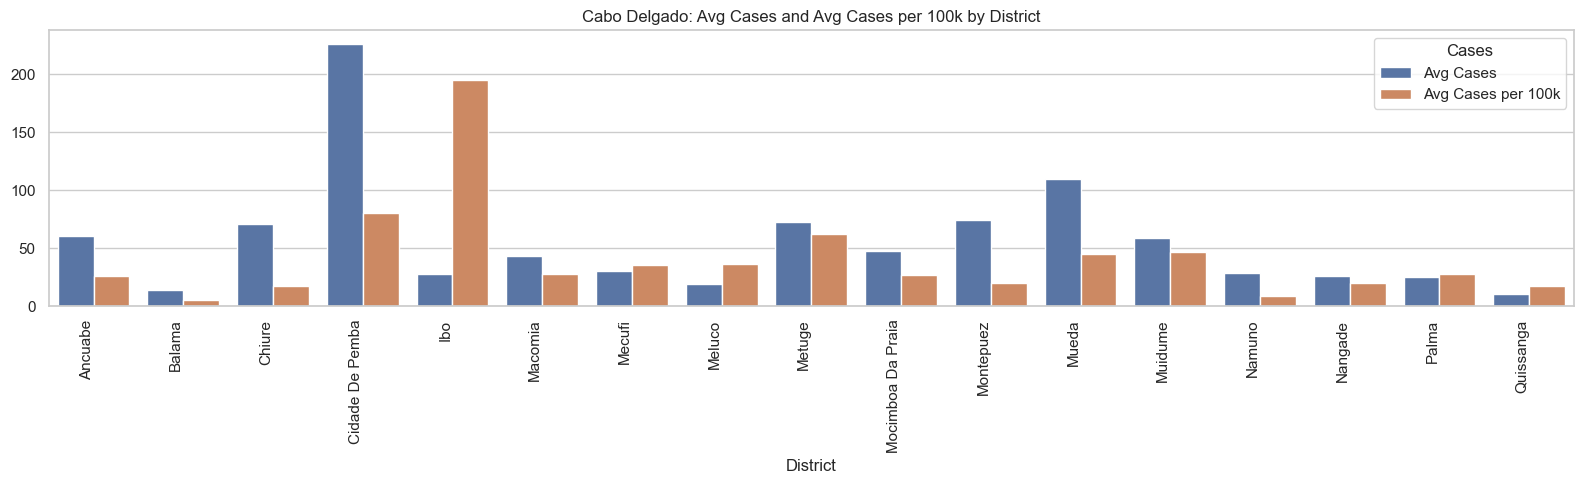

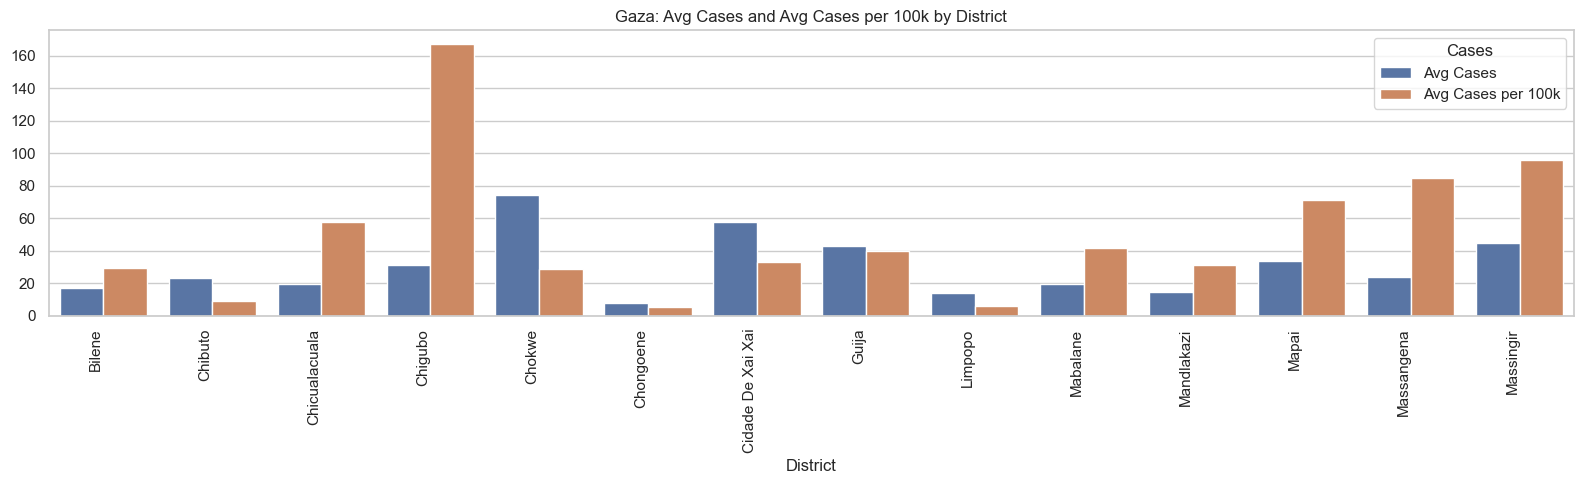

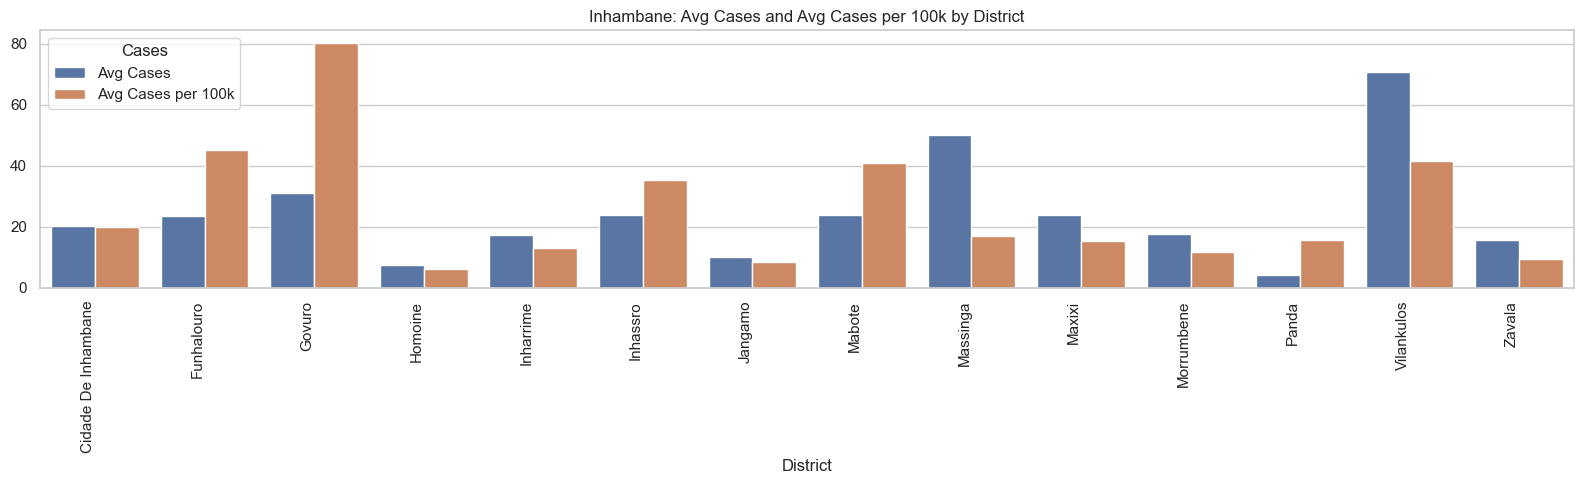

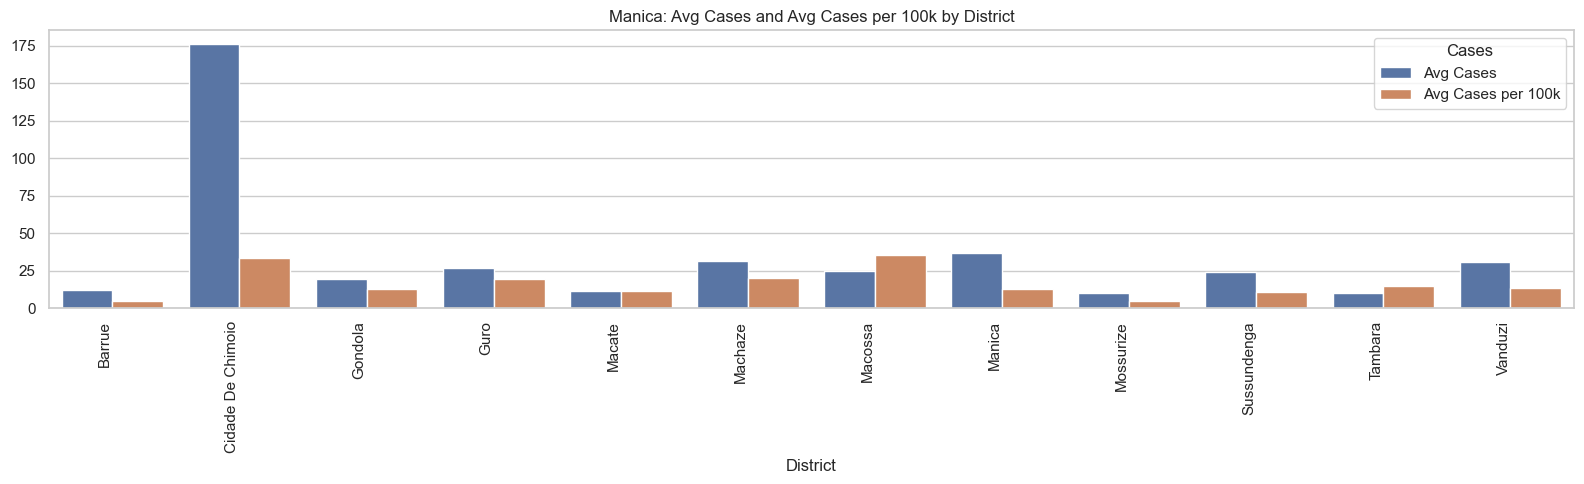

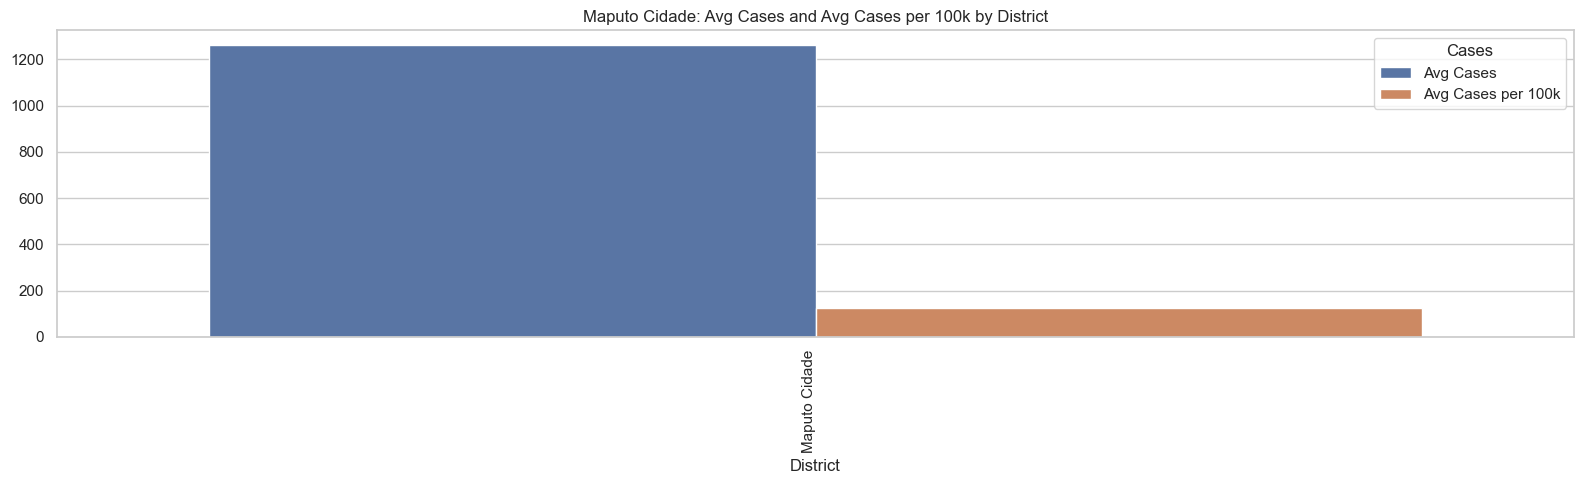

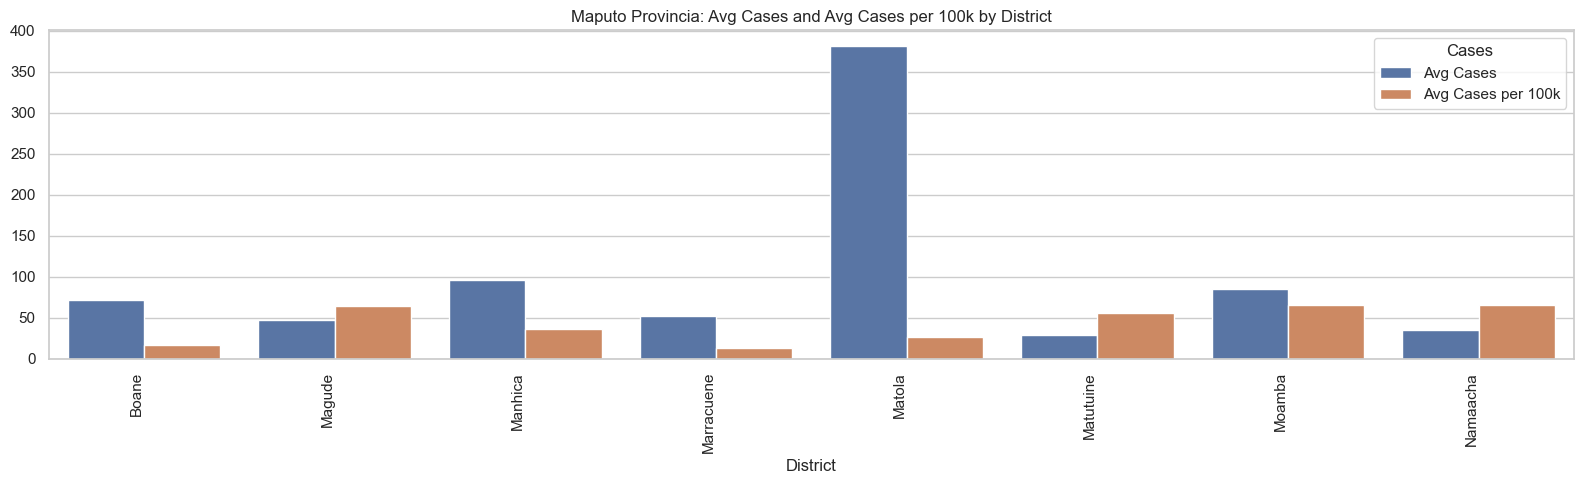

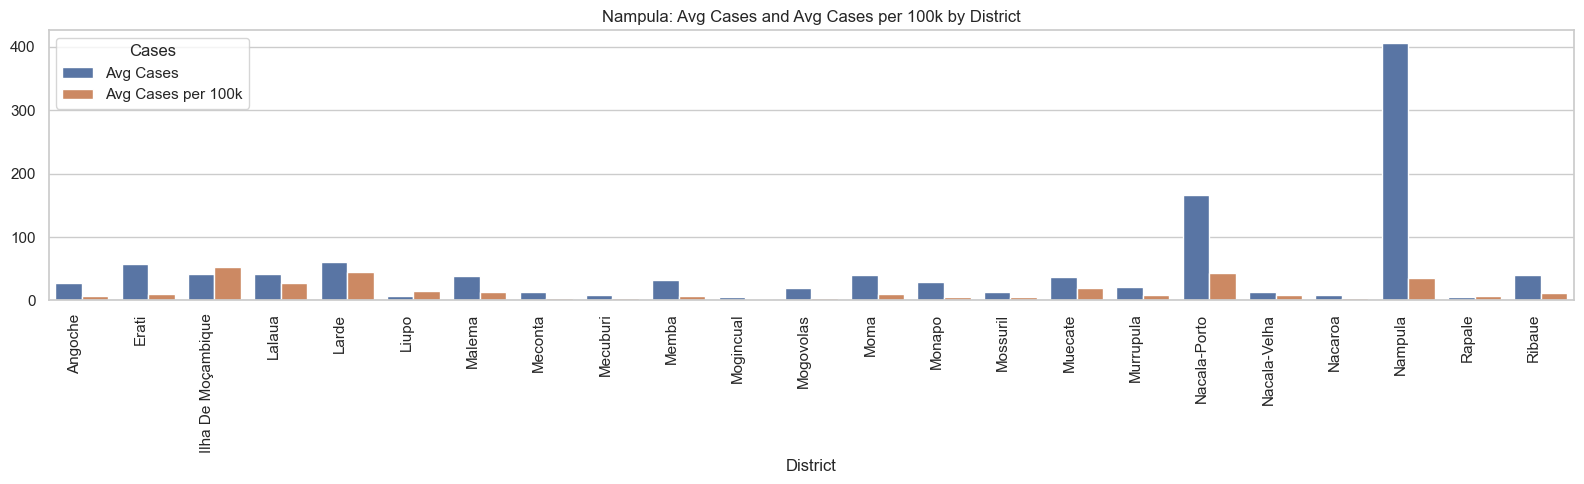

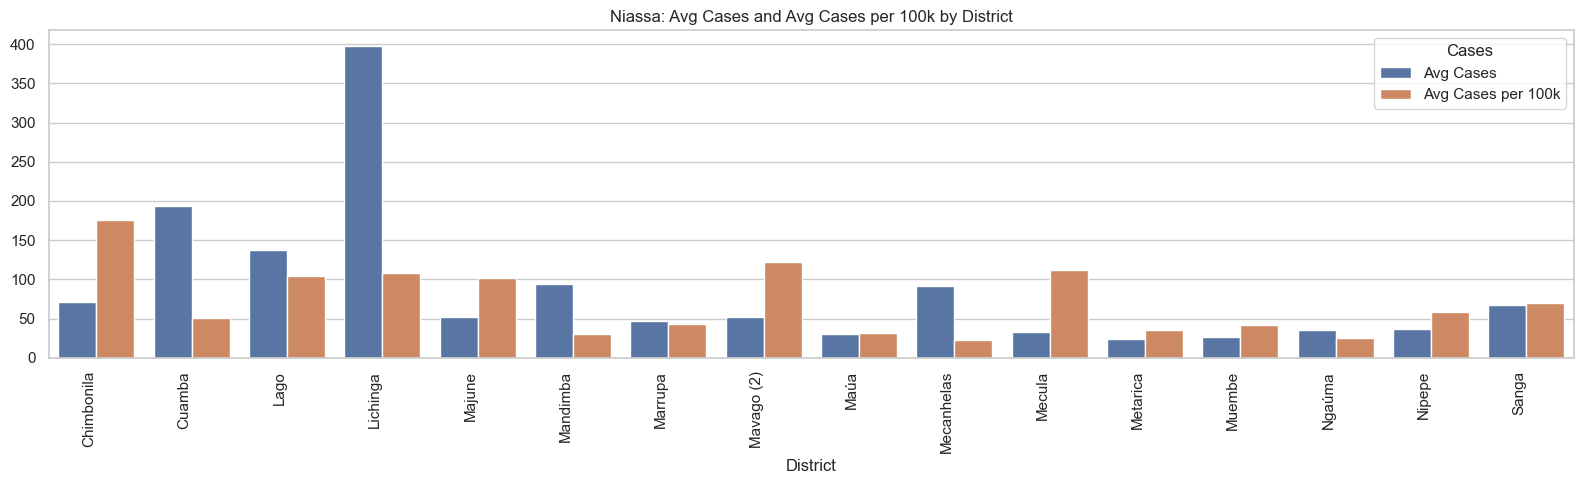

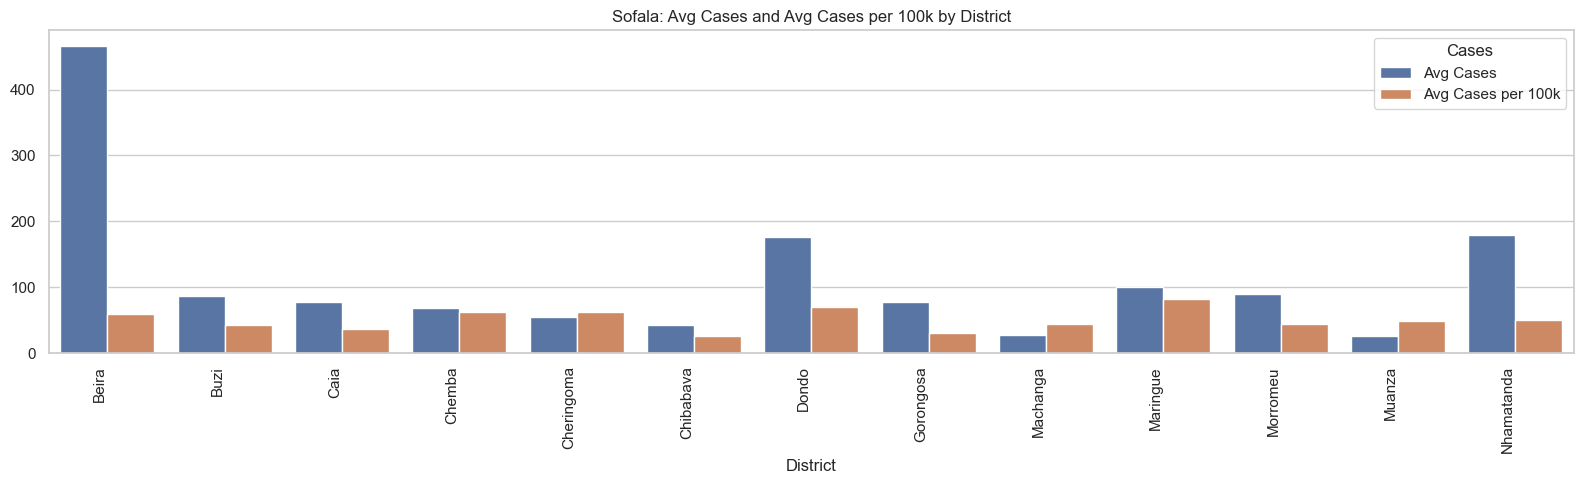

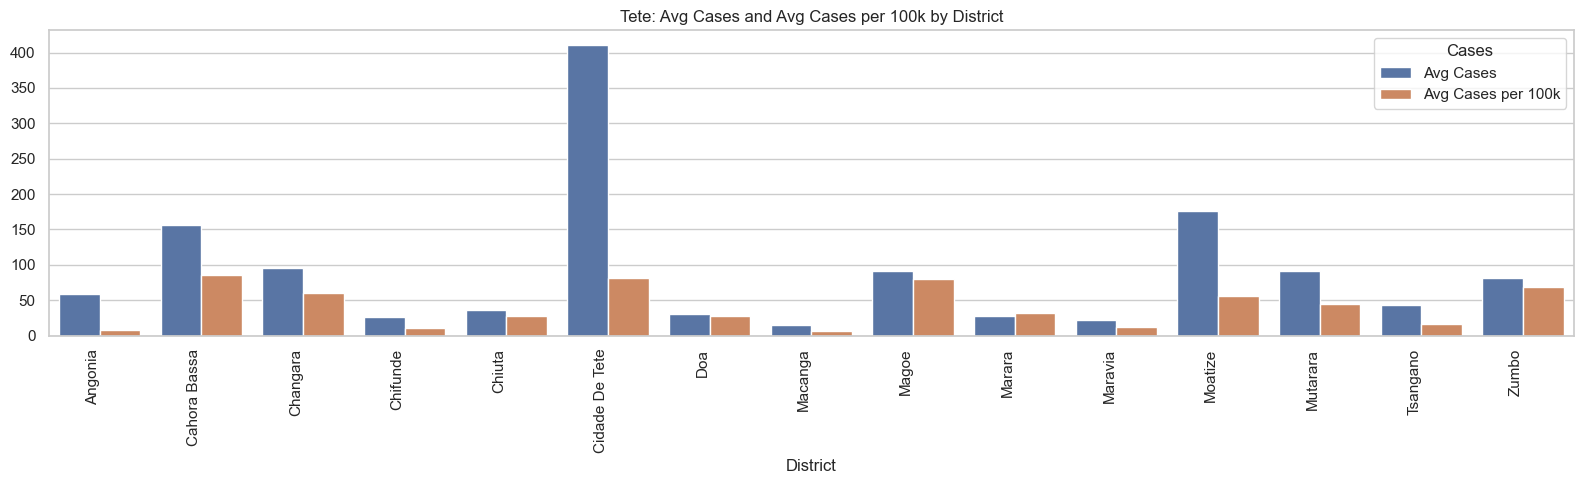

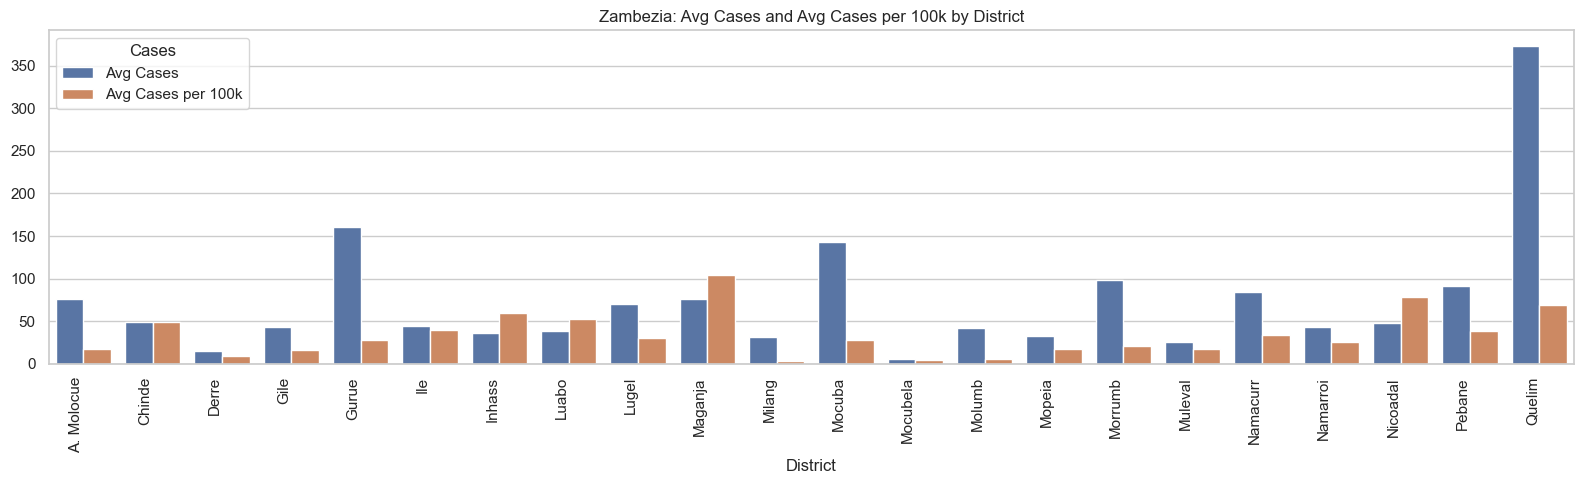

In [27]:
melted = grouped.melt(
    id_vars=["province", "district"],
    value_vars=["average_cases", "average_cases_per_100k"],
    var_name="metric",
    value_name="value",
)

# Rename for cleaner labels
melted["cases"] = melted["metric"].replace(
    {
        "average_cases": "Avg Cases",
        "average_cases_per_100k": "Avg Cases per 100k",
    }
)

# Plot
provinces = melted["province"].unique()

for province in provinces:
    df_prov = melted[melted["province"] == province]

    plt.figure(figsize=(16, 5))
    sns.barplot(
        data=df_prov,
        x="district",
        y="value",
        hue="cases",
        dodge=True,
        errorbar=None,
    )
    plt.title(f"{province}: Avg Cases and Avg Cases per 100k by District")
    plt.xlabel("District")
    plt.xticks(rotation=90, ha="right")
    plt.ylabel("")
    plt.legend(title="Cases")
    plt.tight_layout()
    plt.show()

In [28]:
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
][["year", "week"]].drop_duplicates().sort_values(["year", "week"])
# the number of districts by year and by province when the threshold was crossed
all_years = district_df_with_percentiles["year"].unique()
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
].groupby(["province", "year"])["district"].nunique().unstack(
    fill_value=0
).reindex(
    columns=sorted(all_years), fill_value=0
)

year              2017  2018  2019  2020  2021  2022  2023  2024  2025
province                                                              
Manica               0     0     0     0     0     0     1     0     1
Maputo Cidade        0     1     0     0     0     0     0     0     0
Maputo Provincia     0     1     1     0     0     0     0     0     0
Nampula              0     0     0     1     2     2     0     0     0
Niassa               0     1     0     0     1     2     1     0     0
Sofala               1     0    13     0     0     1    13     0     0
Tete                 0     0     0     0     0     0    15     3     1
Zambezia             0     0     0     1     1     0     1     1     0

In [29]:
# Filter if you want only the crossings
crossed_99th = district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
]

district_trigger_99th = (
    crossed_99th.groupby(["province", "district", "year"])["week"]
    .count()
    .reset_index(name="week_count")
)
district_trigger_99th

province           district  year  week_count
0             Manica  Cidade De Chimoio  2023           5
1             Manica  Cidade De Chimoio  2025           2
2      Maputo Cidade      Maputo Cidade  2018           2
3   Maputo Provincia             Magude  2018           2
4   Maputo Provincia             Magude  2019           1
..               ...                ...   ...         ...
61              Tete              Zumbo  2023           1
62          Zambezia            Maganja  2020           1
63          Zambezia            Maganja  2021           3
64          Zambezia            Maganja  2024           7
65          Zambezia           Nicoadal  2023           1

[66 rows x 4 columns]

In [30]:
district_df_with_percentiles[
    district_df_with_percentiles["district"].isin(
        district_trigger_99th["district"].unique()
    )
]

province district  year  week  cases  cases_winsorized district_norm  \
1035      Tete  Angonia  2018   1.0   43.0              43.0       angonia   
1036      Tete  Angonia  2018   2.0   58.0              58.0       angonia   
1037      Tete  Angonia  2018   3.0   10.0              10.0       angonia   
1038      Tete  Angonia  2018   4.0   67.0              67.0       angonia   
1039      Tete  Angonia  2018   5.0   45.0              45.0       angonia   
...        ...      ...   ...   ...    ...               ...           ...   
60895     Tete    Zumbo  2025  48.0    NaN               NaN         zumbo   
60896     Tete    Zumbo  2025  49.0    NaN               NaN         zumbo   
60897     Tete    Zumbo  2025  50.0    NaN               NaN         zumbo   
60898     Tete    Zumbo  2025  51.0    NaN               NaN         zumbo   
60899     Tete    Zumbo  2025  52.0    NaN               NaN         zumbo   

      matched_name       date  ADM2_PT ADM1_PT  sum_population ADM2_PT_norm  \
1035       Angonia 2018-01-01  Angonia    Tete       692,058.3      angonia   
1036       Angonia 2018-01-08  Angonia    Tete       692,058.3      angonia   
1037       Angonia 2018-01-15  Angonia    Tete       692,058.3      angonia   
1038       Angonia 2018-01-22  Angonia    Tete       692,058.3      angonia   
1039       Angonia 2018-01-29  Angonia    Tete       692,058.3      angonia   
...            ...        ...      ...     ...             ...          ...   
60895        Zumbu 2025-11-24    Zumbu    Tete       118,176.1        zumbu   
60896        Zumbu 2025-12-01    Zumbu    Tete       118,176.1        zumbu   
60897        Zumbu 2025-12-08    Zumbu    Tete       118,176.1        zumbu   
60898        Zumbu 2025-12-15    Zumbu    Tete       118,176.1        zumbu   
60899        Zumbu 2025-12-22    Zumbu    Tete       118,176.1        zumbu   

       cases_per_100k   p99  weekly_pct_increase  above_99th  above_4x  \
1035              6.2 158.0                  NaN       False     False   
1036              8.4 158.0                 34.9       False     False   
1037              1.4 158.0                -82.8       False     False   
1038              9.7 158.0                570.0       False      True   
1039              6.5 158.0                -32.8       False     False   
...               ...   ...                  ...         ...       ...   
60895             NaN 158.0                  NaN       False     False   
60896             NaN 158.0                  NaN       False     False   
60897             NaN 158.0                  NaN       False     False   
60898             NaN 158.0                  NaN       False     False   
60899             NaN 158.0                  NaN       False     False   

       threshold_crossed  adm1_above_limit  adm1_threshold_crossed  \
1035               False             False                   False   
1036               False             False                   False   
1037               False             False                   False   
1038                True             False                   False   
1039               False             False                   False   
...                  ...               ...                     ...   
60895              False             False                   False   
60896              False             False                   False   
60897              False             False                   False   
60898              False             False                   False   
60899              False             False                   False   

       district_consec_crossing  three_consec_crossing  
1035                      False                  False  
1036                      False                  False  
1037                      False                  False  
1038                      False                  False  
1039                      False                  False  
...                         ...                 

In [31]:
month_num = {
    month: idx for idx, month in enumerate(calendar.month_name) if month
}


def highlight_month_boxes(data, cerf_y_lim="cases_per_100k", **kwargs):
    ax = plt.gca()

    # Add vertical lines
    consec_dates = data.loc[
        data["three_consec_crossing"], "date"
    ].sort_values()

    if not consec_dates.empty:
        # Convert to periods (daily)
        diffs = consec_dates.diff().dt.days.fillna(1)
        group = (diffs != 7).cumsum()  # Use 7 for weekly data

        for _, g in consec_dates.groupby(group):
            continue
            start = g.min()
            end = g.max()
            y_min = data.loc[
                (data["date"] >= start) & (data["date"] <= end),
                "cases_per_100k",
            ].min()
            y_max = data.loc[
                (data["date"] >= start) & (data["date"] <= end),
                "cases_per_100k",
            ].max()
            ax.add_patch(
                Rectangle(
                    (start, 0),
                    end - start,
                    ax.get_ylim()[1],
                    facecolor="red",
                    alpha=0.5,
                    edgecolor="red",
                )
            )

    # Highlight selected months
    for year, month in highlight_cells:
        month_index = month_num.get(month)
        if not month_index:
            continue

        mask = (data["date"].dt.year == year) & (
            data["date"].dt.month == month_index
        )
        if not mask.any():
            continue

        month_data = data.loc[mask]
        x_min = month_data["date"].min()
        x_max = month_data["date"].max()
        y_min = max(0, month_data[cerf_y_lim].min() - 5)
        y_max = month_data[cerf_y_lim].max() + 5

        ax.add_patch(
            Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                facecolor="green",
                edgecolor="green",
                alpha=0.5,
                linewidth=1,
            )
        )

In [32]:
unique_provinces = district_df_with_percentiles["province"].unique()

for province in unique_provinces:
    continue
    subset = district_df_with_percentiles[
        (district_df_with_percentiles["province"] == province)
        & (
            district_df_with_percentiles["district"].isin(
                district_trigger_99th["district"].unique()
            )
        )
    ]

    if subset.empty:
        continue

    g = sns.FacetGrid(
        subset,
        col="district",
        col_wrap=1,
        sharex=False,
        sharey=False,
        height=3,
        aspect=5,
    )

    # Plot main line
    g.map_dataframe(sns.lineplot, x="date", y="cases_per_100k")
    # g.map_dataframe(
    #    sns.lineplot,
    #    x="date",
    #    y="cases",
    #    linestyle="--",
    #    color="orange",
    #    label="Actual Cases",
    # )

    # Add horizontal 99th percentile line
    g.map_dataframe(
        lambda data, color, **kws: (
            plt.axhline(y=data["p99"].iloc[0], color="red", linestyle="--"),
            plt.text(
                data["date"].min(),
                data["p99"].iloc[0],
                "99th percentile",
                color="red",
                fontsize=9,
                verticalalignment="bottom",
                horizontalalignment="left",
            ),
        ),
    )
    g.map_dataframe(
        lambda data, **kws: plt.scatter(
            data.loc[data["weekly_pct_increase"] >= 400, "date"],
            data.loc[data["weekly_pct_increase"] >= 400, "cases_per_100k"],
            color="red",
            s=30,
            zorder=5,
        )
    )

    # Add vertical red lines where condition is true
    def add_vertical_lines(data, **kwargs):
        for date in data.loc[data["three_consec_crossing"], "date"]:
            plt.axvline(x=date, color="red", linestyle="-", linewidth=1)

    # g.map_dataframe(add_vertical_lines)
    g.map_dataframe(highlight_month_boxes)
    g.set_titles(f"{{col_name}}")
    g.set_axis_labels("", "Cases Per 100k")

    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(0)
    plt.suptitle(f"{province.upper()}", fontsize=18, weight="bold", y=1)
    plt.tight_layout()
    plt.figtext(
        0.5,
        -0.08,
        "Red bars show dates when the 3-week consecutive threshold above the 99th percentile or 4x increase is reached. \n "
        "Red dots indicate weeks where weekly case increase was 4x or higher. \n"
        "Green boxes highlight months with a CERF allocation.",
        wrap=True,
        horizontalalignment="center",
        fontsize=10,
    )
    plt.show()

In [33]:
# Copy dataframe
df = district_df_with_percentiles.copy()

# Extract month and year
df["month"] = pd.to_datetime(df["date"]).dt.month_name()
df["year"] = pd.to_datetime(df["date"]).dt.year

# --- District-level trigger (D) ---
district_trigger_df = df[df["district_consec_crossing"] == True].copy()
district_summary = (
    district_trigger_df.groupby(["ADM1_PT", "year", "month"])
    .agg(
        num_trigger_weeks=("week", "nunique"),
        districts=("district", lambda x: ", ".join(sorted(set(x)))),
    )
    .reset_index()
    .rename(columns={"ADM1_PT": "province"})
)
district_summary["district_count"] = (
    district_summary["districts"]
    .str.split(",")
    .apply(lambda x: len([d.strip() for d in x if d.strip()]))
)
district_summary["activation_type"] = "D"


# --- Provincial-level trigger (P) ---
prov_trigger_df = df[df["adm1_threshold_crossed"] == True].copy()
prov_summary = (
    prov_trigger_df.groupby(["ADM1_PT", "year", "month"])
    .agg(
        num_trigger_weeks=("week", "nunique"),
        districts=("district", lambda x: ", ".join(sorted(set(x)))),
    )
    .reset_index()
    .rename(columns={"ADM1_PT": "province"})
)
prov_summary["district_count"] = (
    prov_summary["districts"]
    .str.split(",")
    .apply(lambda x: len([d.strip() for d in x if d.strip()]))
)
prov_summary["activation_type"] = "P"


# --- Combine both ---
summary = pd.concat([district_summary, prov_summary], ignore_index=True)
summary = summary.sort_values(["province", "year", "month", "activation_type"])

In [34]:
# Copy dataframe
df = district_df_with_percentiles.copy()

# Extract week and year
df["year"] = pd.to_datetime(df["date"]).dt.year
df["week"] = pd.to_datetime(df["date"]).dt.isocalendar().week.astype(int)

# --- District-level trigger (D) ---
district_trigger_df = df[df["district_consec_crossing"] == True].copy()
district_summary_wk = (
    district_trigger_df.groupby(["ADM1_PT", "year", "week"])
    .agg(
        num_trigger_days=("date", "nunique"),
        districts=("district", lambda x: ", ".join(sorted(set(x)))),
    )
    .reset_index()
    .rename(columns={"ADM1_PT": "province"})
)

district_summary_wk["district_count"] = (
    district_summary_wk["districts"]
    .str.split(",")
    .apply(lambda x: len([d.strip() for d in x if d.strip()]))
)

# Keep only if at least 2 districts triggered simultaneously
district_summary_wk = district_summary_wk[
    district_summary_wk["district_count"] >= 2
]

district_summary_wk["activation_type"] = "D"


# --- Provincial-level trigger (P) ---
prov_trigger_df = df[df["adm1_threshold_crossed"] == True].copy()
prov_summary_wk = (
    prov_trigger_df.groupby(["ADM1_PT", "year", "week"])
    .agg(
        num_trigger_days=("date", "nunique"),
        districts=("district", lambda x: ", ".join(sorted(set(x)))),
    )
    .reset_index()
    .rename(columns={"ADM1_PT": "province"})
)
prov_summary_wk["district_count"] = (
    prov_summary_wk["districts"]
    .str.split(",")
    .apply(lambda x: len([d.strip() for d in x if d.strip()]))
)
prov_summary_wk["activation_type"] = "P"

# --- Combine both ---
summary_weekly = pd.concat(
    [district_summary_wk, prov_summary_wk], ignore_index=True
)
summary_weekly = summary_weekly.sort_values(
    ["province", "year", "week", "activation_type"]
)

summary_weekly

province  year  week  num_trigger_days  \
0   Nampula  2021     6                 1   
1   Nampula  2021     7                 1   
2   Nampula  2021     8                 1   
3   Nampula  2021     9                 1   
4   Nampula  2021    10                 1   
5   Nampula  2021    11                 1   
6   Nampula  2022     7                 1   
7    Sofala  2019    14                 1   
8    Sofala  2019    15                 1   
9    Sofala  2019    16                 1   
10   Sofala  2019    17                 1   
11   Sofala  2019    18                 1   
12   Sofala  2019    19                 1   
13   Sofala  2019    20                 1   
14   Sofala  2023    13                 1   
15     Tete  2023     6                 1   

                                            districts  district_count  \
0                    Ilha De Moçambique, Nacala-Porto               2   
1                    Ilha De Moçambique, Nacala-Porto               2   
2                    Ilha De Moçambique, Nacala-Porto               2   
3                    Ilha De Moçambique, Nacala-Porto               2   
4                    Ilha De Moçambique, Nacala-Porto               2   
5                    Ilha De Moçambique, Nacala-Porto               2   
6                                Lalaua, Nacala-Porto               2   
7   Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
8   Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
9   Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
10  Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
11  Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
12  Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
13  Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
14  Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
15  Angonia, Cahora Bassa, Changara, Chifunde, Chi...              15   

   activation_type  
0                D  
1                D  
2                D  
3                D  
4                D  
5                D  
6                D  
7                P  
8                P  
9                P  
10               P  
11               P  
12               P  
13               P  
14               P  
15               P

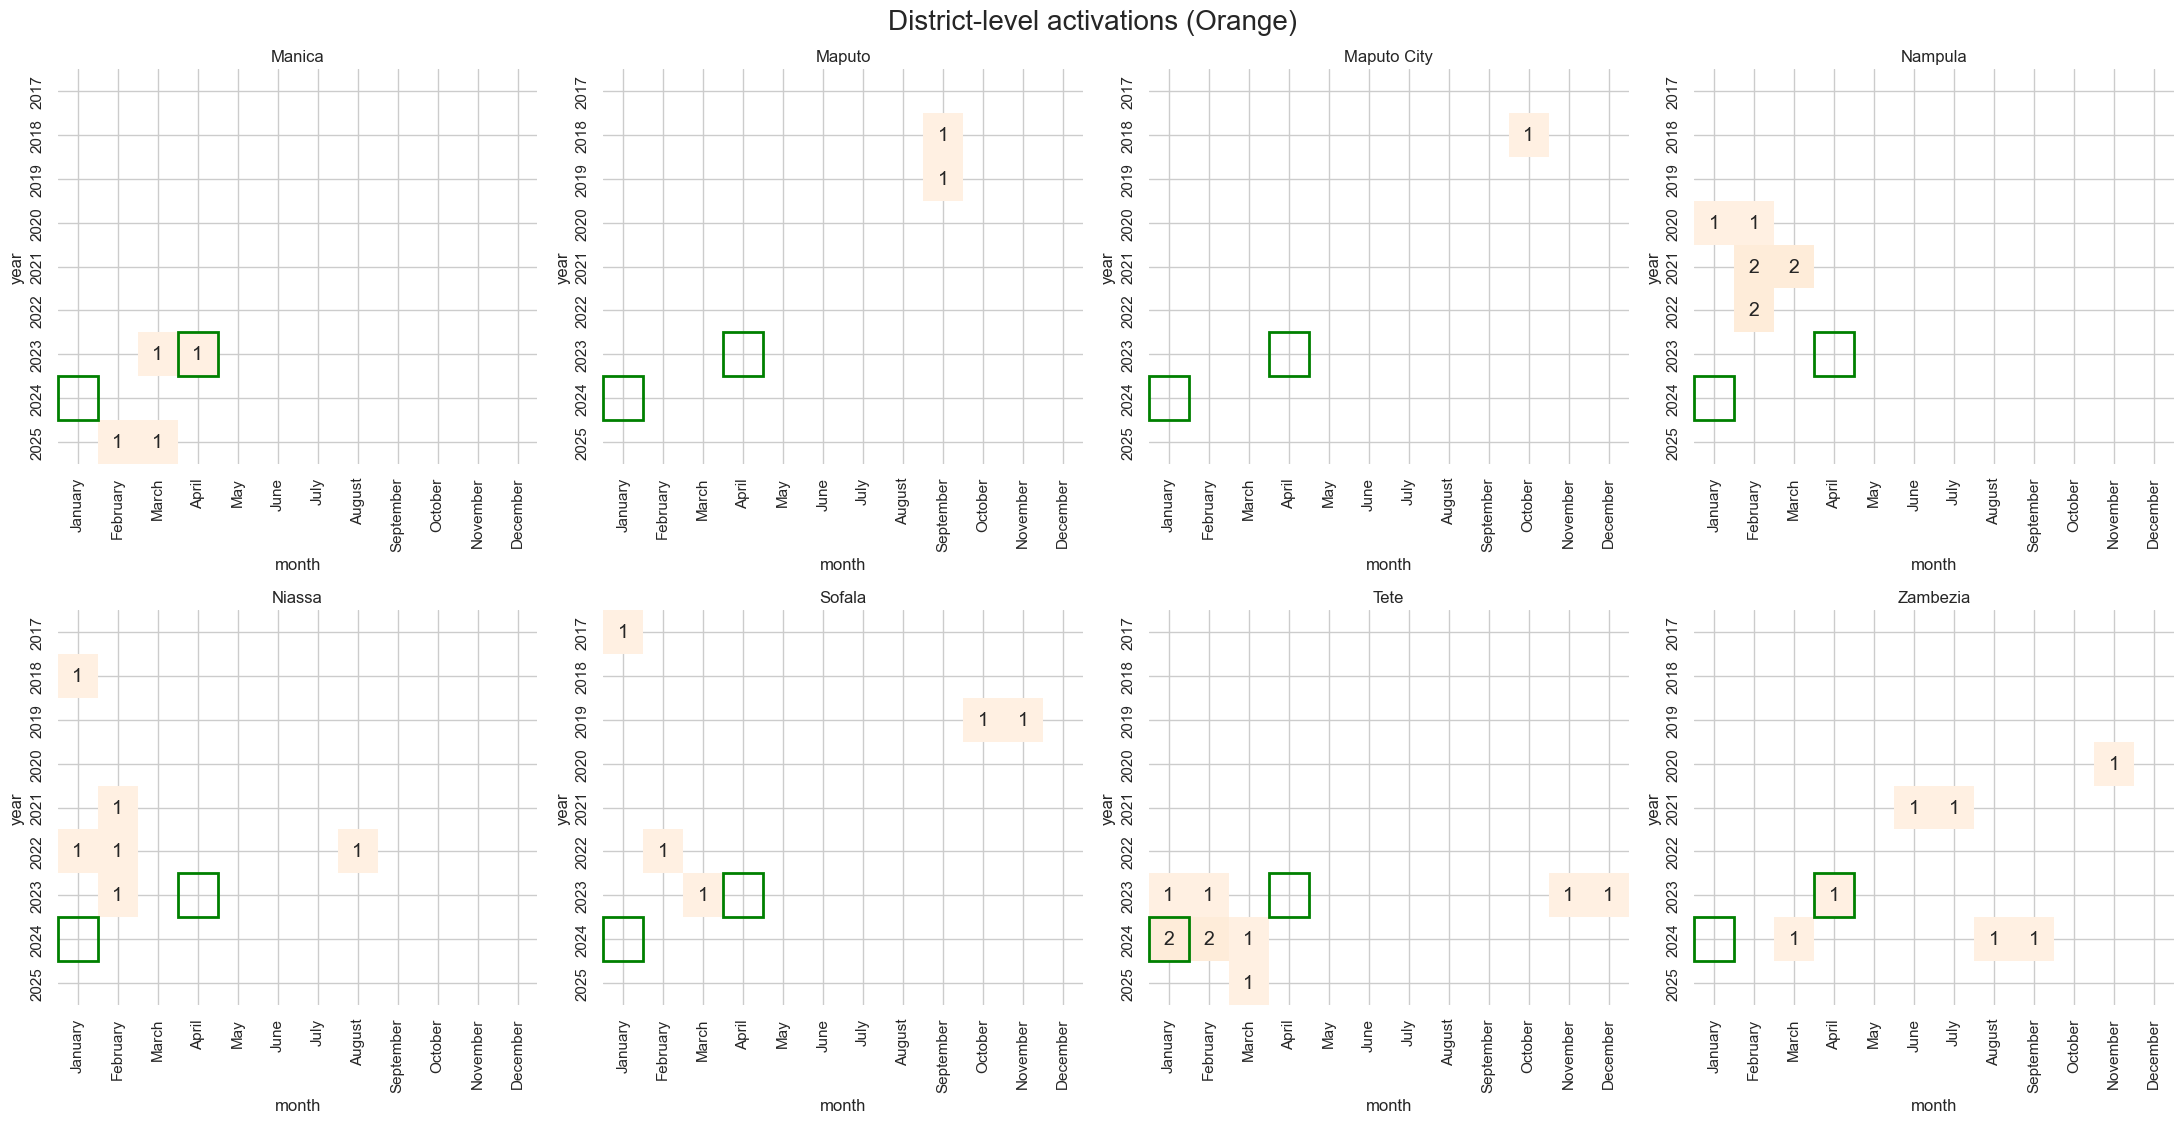

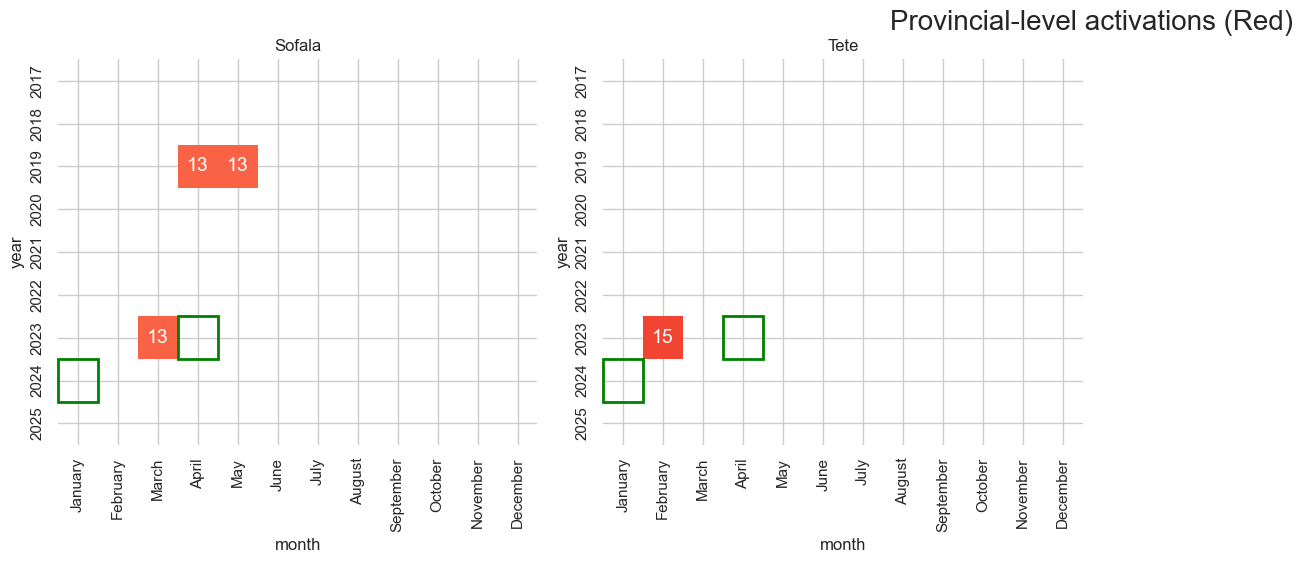

In [35]:
all_years = list(range(summary["year"].min(), summary["year"].max() + 1))


def heatmap_with_all_years(data, cmap, **kwargs):
    table = data.pivot_table(
        index="year",
        columns="month",
        values="district_count",
        aggfunc="first",
        observed=False,
    ).reindex(index=all_years, columns=month_order)

    sns.heatmap(
        table,
        cmap=cmap,
        cbar=False,
        annot=True,
        fmt=".0f",
        linewidths=0,
        vmin=0,
        vmax=25,
        annot_kws={"size": 14},
    )

    ax = plt.gca()
    for year, month in highlight_cells:
        try:
            row_idx = table.index.get_loc(year)
            col_idx = table.columns.get_loc(month)
            ax.add_patch(
                plt.Rectangle(
                    (col_idx, row_idx),
                    1,
                    1,
                    fill=False,
                    edgecolor="green",
                    linewidth=2,
                    clip_on=False,
                )
            )
        except KeyError:
            continue


# --- District-level (orange) ---
g_d = sns.FacetGrid(
    summary[summary["activation_type"] == "D"],
    col="province",
    col_wrap=4,
    height=5.5,
    aspect=1,
    sharex=False,
    sharey=False,
)
g_d.map_dataframe(heatmap_with_all_years, cmap="Oranges")
g_d.set_titles(col_template="{col_name}", fontsize=16)
g_d.fig.suptitle("District-level activations (Orange)", fontsize=20, y=1.02)
plt.show()

# --- Provincial-level (red) ---
g_p = sns.FacetGrid(
    summary[summary["activation_type"] == "P"],
    col="province",
    col_wrap=4,
    height=5.5,
    aspect=1,
    sharex=False,
    sharey=False,
)
g_p.map_dataframe(heatmap_with_all_years, cmap="Reds")
g_p.set_titles(col_template="{col_name}", fontsize=16)
g_p.fig.suptitle("Provincial-level activations (Red)", fontsize=20, y=1.02)
plt.show()

In [36]:
activated = summary[summary["district_count"] > 0]

activated_provinces_monthly = (
    activated[["year", "month", "province"]]
    .drop_duplicates()
    .sort_values(["year", "month", "province"])
)

activated_by_year_month = (
    activated_provinces_monthly.groupby(["year", "month"], observed=False)[
        "province"
    ]
    .apply(list)
    .reset_index()
)

In [37]:
# Collapse to month level from summary_weekly
summary_monthly = summary_weekly.copy()
summary_monthly["date"] = pd.to_datetime(
    summary_monthly["year"].astype(str)
    + summary_monthly["week"].astype(str)
    + "1",
    format="%G%V%u",
)
summary_monthly["month"] = summary_monthly["date"].dt.month_name()
summary_monthly["month"] = pd.Categorical(
    summary_monthly["month"], categories=month_order, ordered=True
)

# Keep unique province-activation per month
summary_monthly = summary_monthly.drop_duplicates(
    subset=["province", "year", "month", "activation_type"]
)

# Build cell dictionary
years = sorted(summary_monthly["year"].unique())
cell = {(y, m): [] for y in years for m in month_order}
for _, r in summary_monthly.iterrows():
    label = f"{r['province']}({r['activation_type']})"
    cell[(r["year"], r["month"])].append(label)

# Create grid with compact strings (semicolon separated)
grid_text = [
    ["; ".join(sorted(cell[(y, m)])) for m in month_order] for y in years
]

# Build DataFrame
table = pd.DataFrame(grid_text, index=years, columns=month_order)
table.index.name = "Year"

from IPython.display import display

display(table)

January    February       March      April        May June July August  \
Year                                                                          
2019                                  Sofala(P)  Sofala(P)                    
2021          Nampula(D)  Nampula(D)                                          
2022          Nampula(D)                                                      
2023             Tete(P)   Sofala(P)                                          

     September October November December  
Year                                      
2019                                      
2021                                      
2022                                      
2023

In [41]:
summary_weekly

province  year  week  num_trigger_days  \
0   Nampula  2021     6                 1   
1   Nampula  2021     7                 1   
2   Nampula  2021     8                 1   
3   Nampula  2021     9                 1   
4   Nampula  2021    10                 1   
5   Nampula  2021    11                 1   
6   Nampula  2022     7                 1   
7    Sofala  2019    14                 1   
8    Sofala  2019    15                 1   
9    Sofala  2019    16                 1   
10   Sofala  2019    17                 1   
11   Sofala  2019    18                 1   
12   Sofala  2019    19                 1   
13   Sofala  2019    20                 1   
14   Sofala  2023    13                 1   
15     Tete  2023     6                 1   

                                            districts  district_count  \
0                    Ilha De Moçambique, Nacala-Porto               2   
1                    Ilha De Moçambique, Nacala-Porto               2   
2                    Ilha De Moçambique, Nacala-Porto               2   
3                    Ilha De Moçambique, Nacala-Porto               2   
4                    Ilha De Moçambique, Nacala-Porto               2   
5                    Ilha De Moçambique, Nacala-Porto               2   
6                                Lalaua, Nacala-Porto               2   
7   Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
8   Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
9   Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
10  Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
11  Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
12  Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
13  Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
14  Beira, Buzi, Caia, Chemba, Cheringoma, Chibaba...              13   
15  Angonia, Cahora Bassa, Changara, Chifunde, Chi...              15   

   activation_type  
0                D  
1                D  
2                D  
3                D  
4                D  
5                D  
6                D  
7                P  
8                P  
9                P  
10               P  
11               P  
12               P  
13               P  
14               P  
15               P

In [38]:
from datetime import timedelta

# Collapse to month level from summary_weekly
summary_monthly = summary_weekly.copy()
summary_monthly["date"] = pd.to_datetime(
    summary_monthly["year"].astype(str)
    + summary_monthly["week"].astype(str)
    + "1",
    format="%G%V%u",
)
summary_monthly["month"] = summary_monthly["date"].dt.month_name()
summary_monthly["month"] = pd.Categorical(
    summary_monthly["month"], categories=month_order, ordered=True
)

# Keep unique province-activation per month
summary_monthly = summary_monthly.drop_duplicates(
    subset=["province", "year", "month", "activation_type"]
).sort_values(["province", "date"])

# --- Apply 6-month silence per province ---
silenced_rows = []
last_alert = {}

for _, row in summary_monthly.iterrows():
    prov = row["province"]
    d = row["date"]

    if prov in last_alert:
        # If less than 6 months since last alert → skip
        if (d - last_alert[prov]).days < 183:
            continue

    silenced_rows.append(row)
    last_alert[prov] = d

summary_silenced = pd.DataFrame(silenced_rows)

# --- Build full year-month grid (2017–2025) ---
all_years = list(range(2017, 2026))
cell = {(y, m): [] for y in all_years for m in month_order}

for _, r in summary_silenced.iterrows():
    label = f"{r['province']}({r['activation_type']})"
    cell[(r["year"], r["month"])].append(label)

# Build grid (semicolon-separated labels)
grid_text = [
    ["; ".join(sorted(cell[(y, m)])) for m in month_order] for y in all_years
]

# Build DataFrame
table = pd.DataFrame(grid_text, index=all_years, columns=month_order)
table.index.name = "Year"

from IPython.display import display

display(table)

January    February      March      April May June July August September  \
Year                                                                            
2017                                                                            
2018                                                                            
2019                                 Sofala(P)                                  
2020                                                                            
2021          Nampula(D)                                                        
2022          Nampula(D)                                                        
2023             Tete(P)  Sofala(P)                                             
2024                                                                            
2025                                                                            

     October November December  
Year                            
2017                            
2018                            
2019                            
2020                            
2021                            
2022                            
2023                            
2024                            
2025

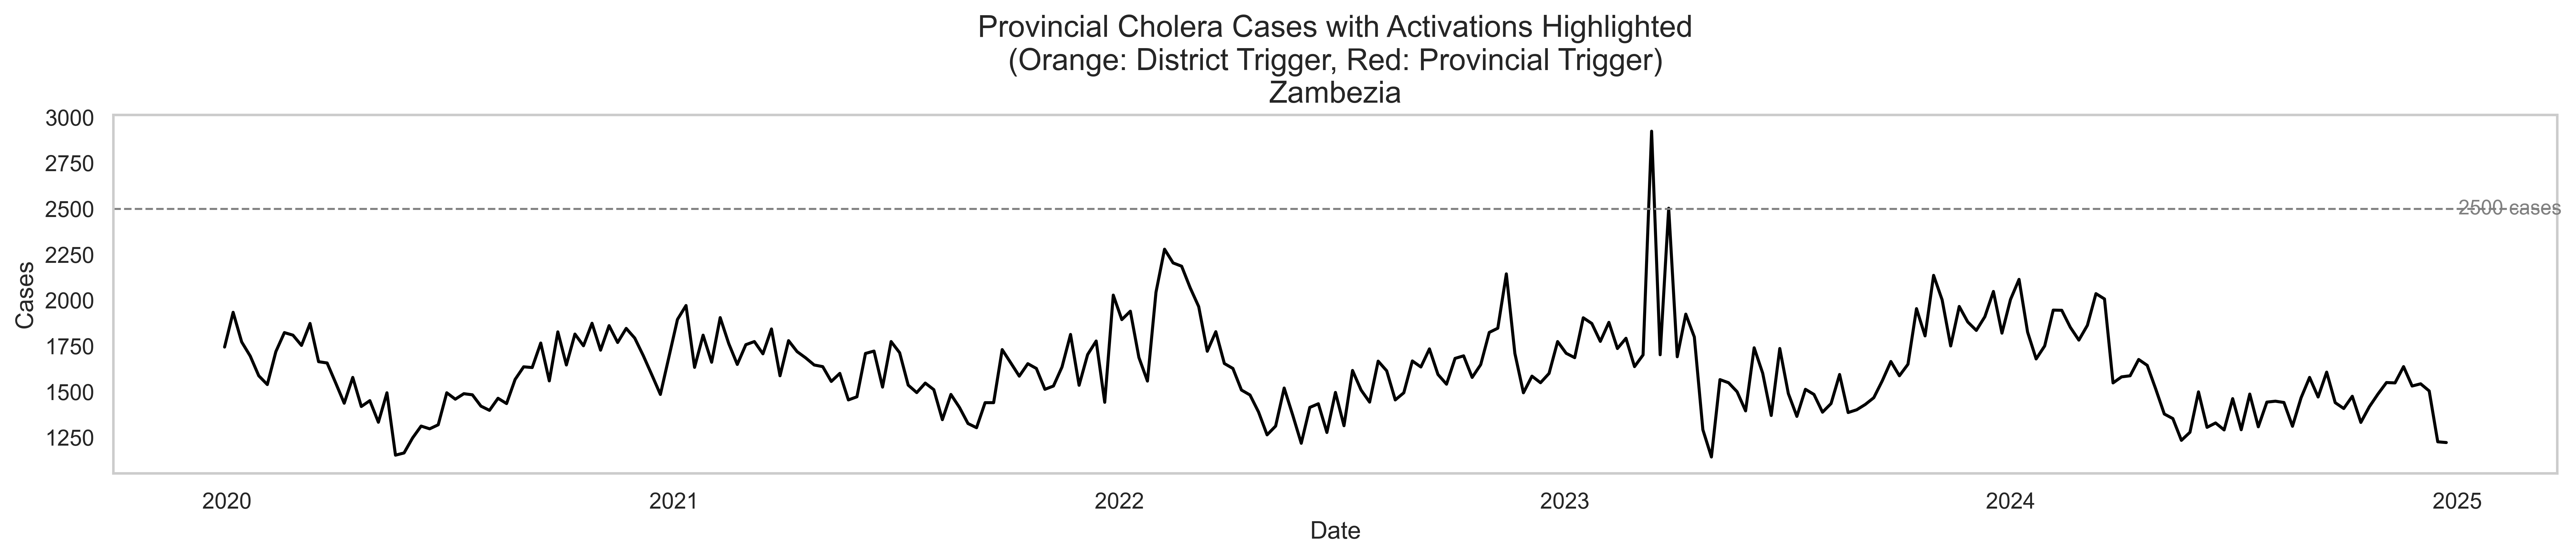

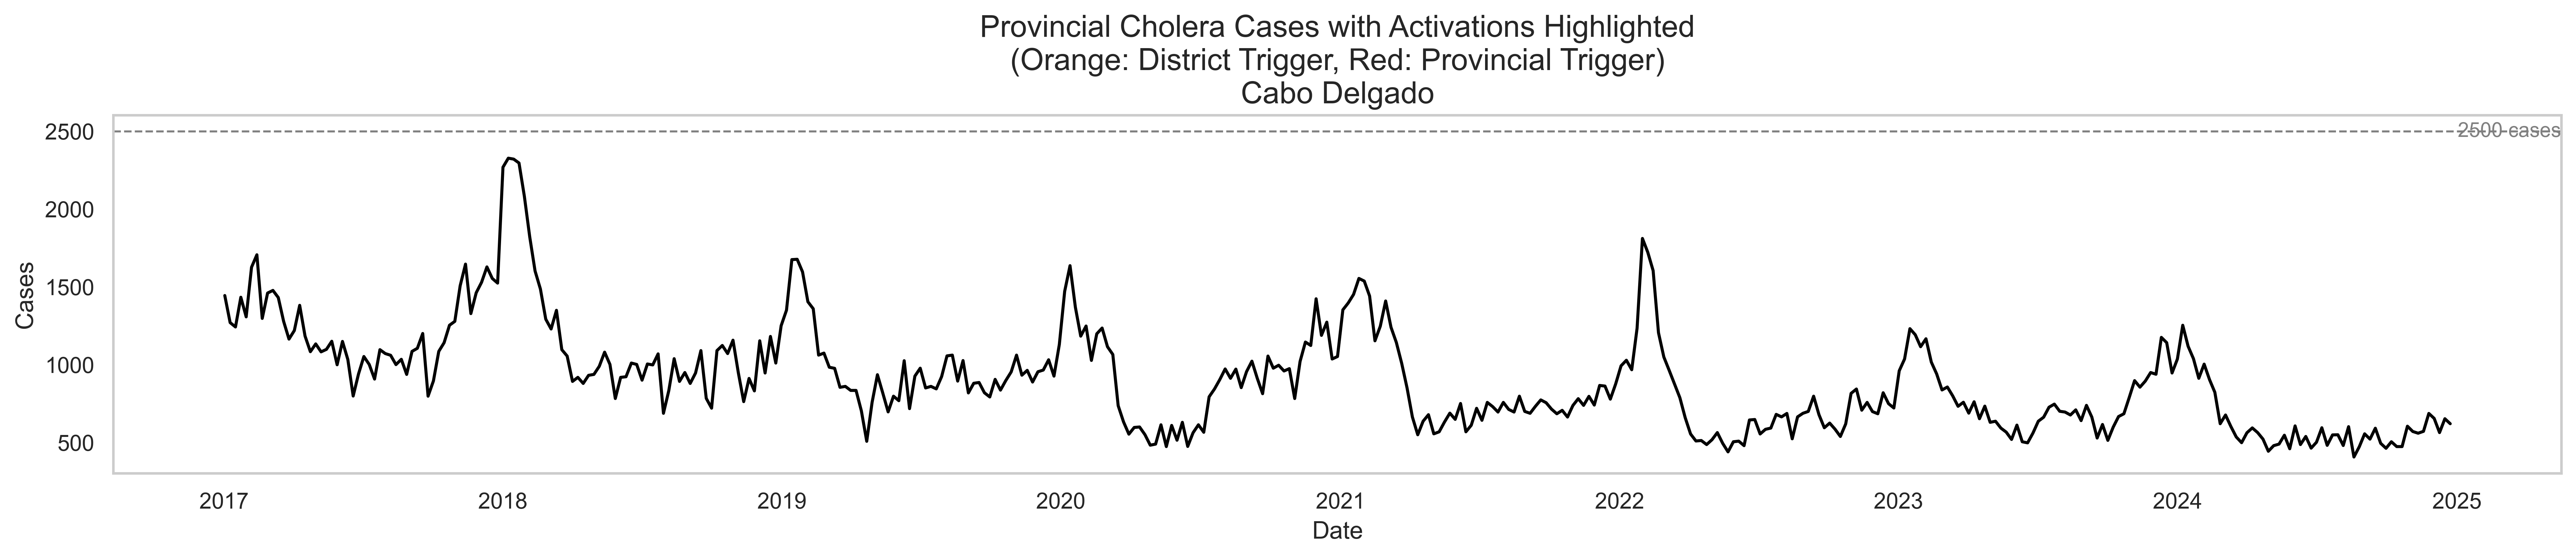

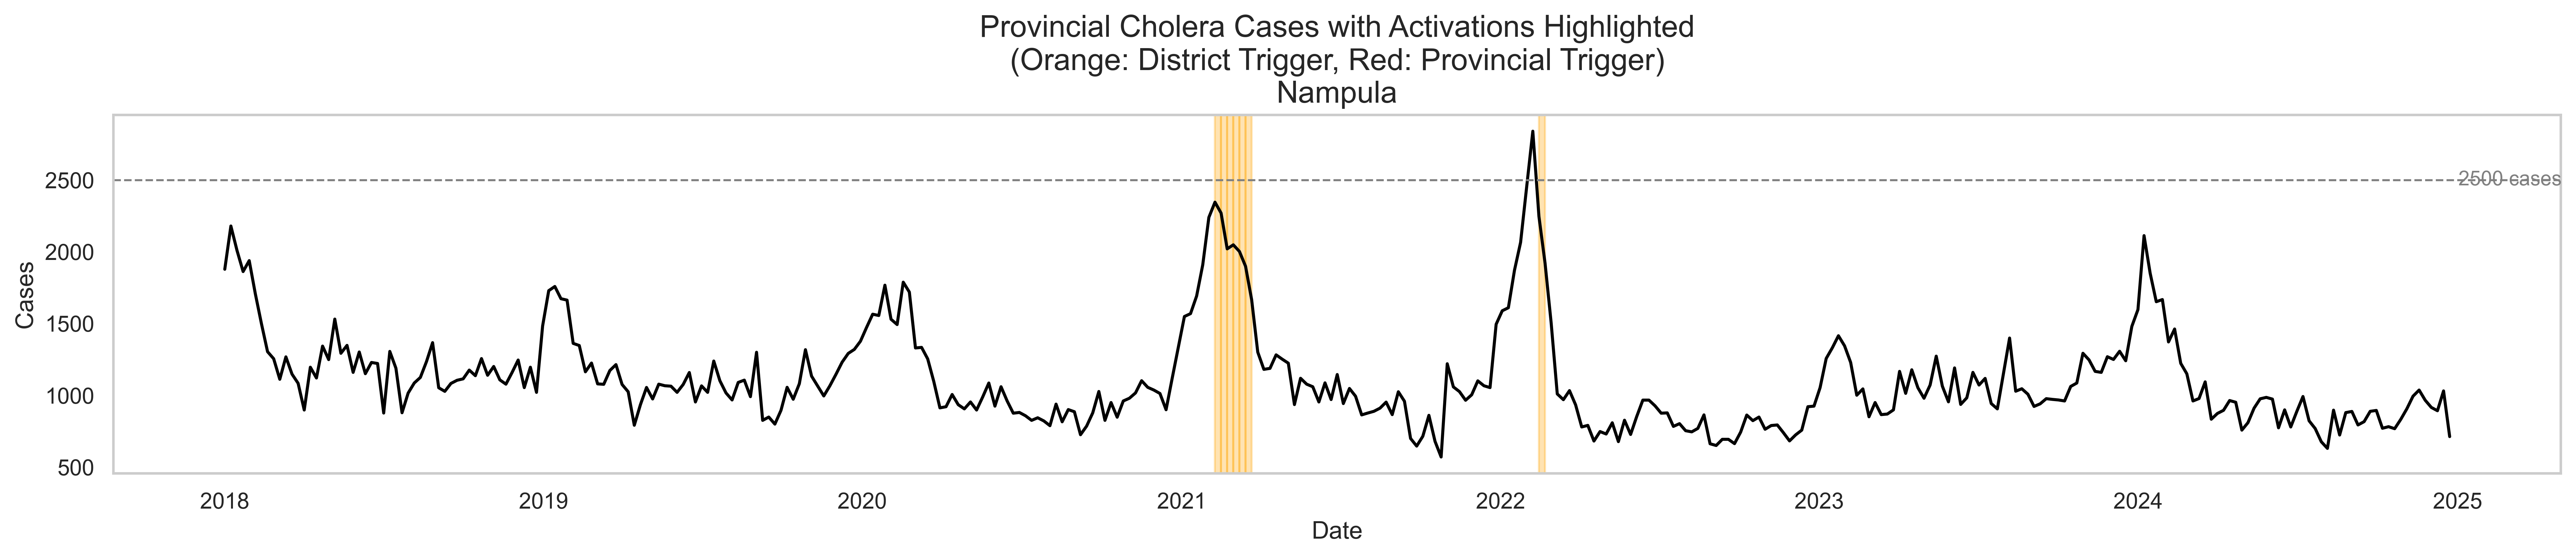

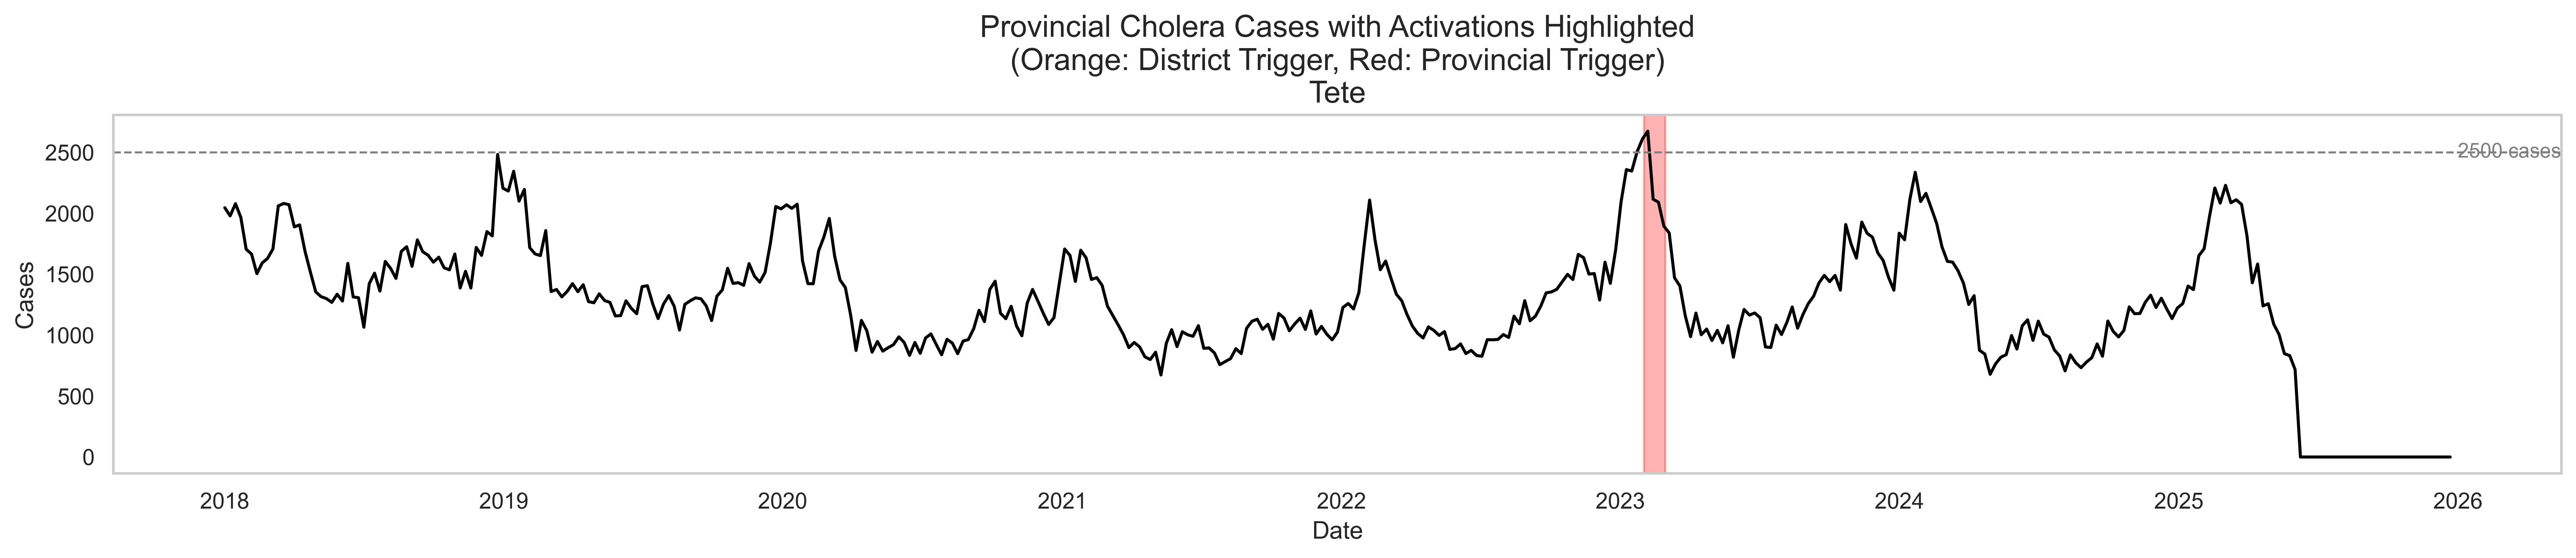

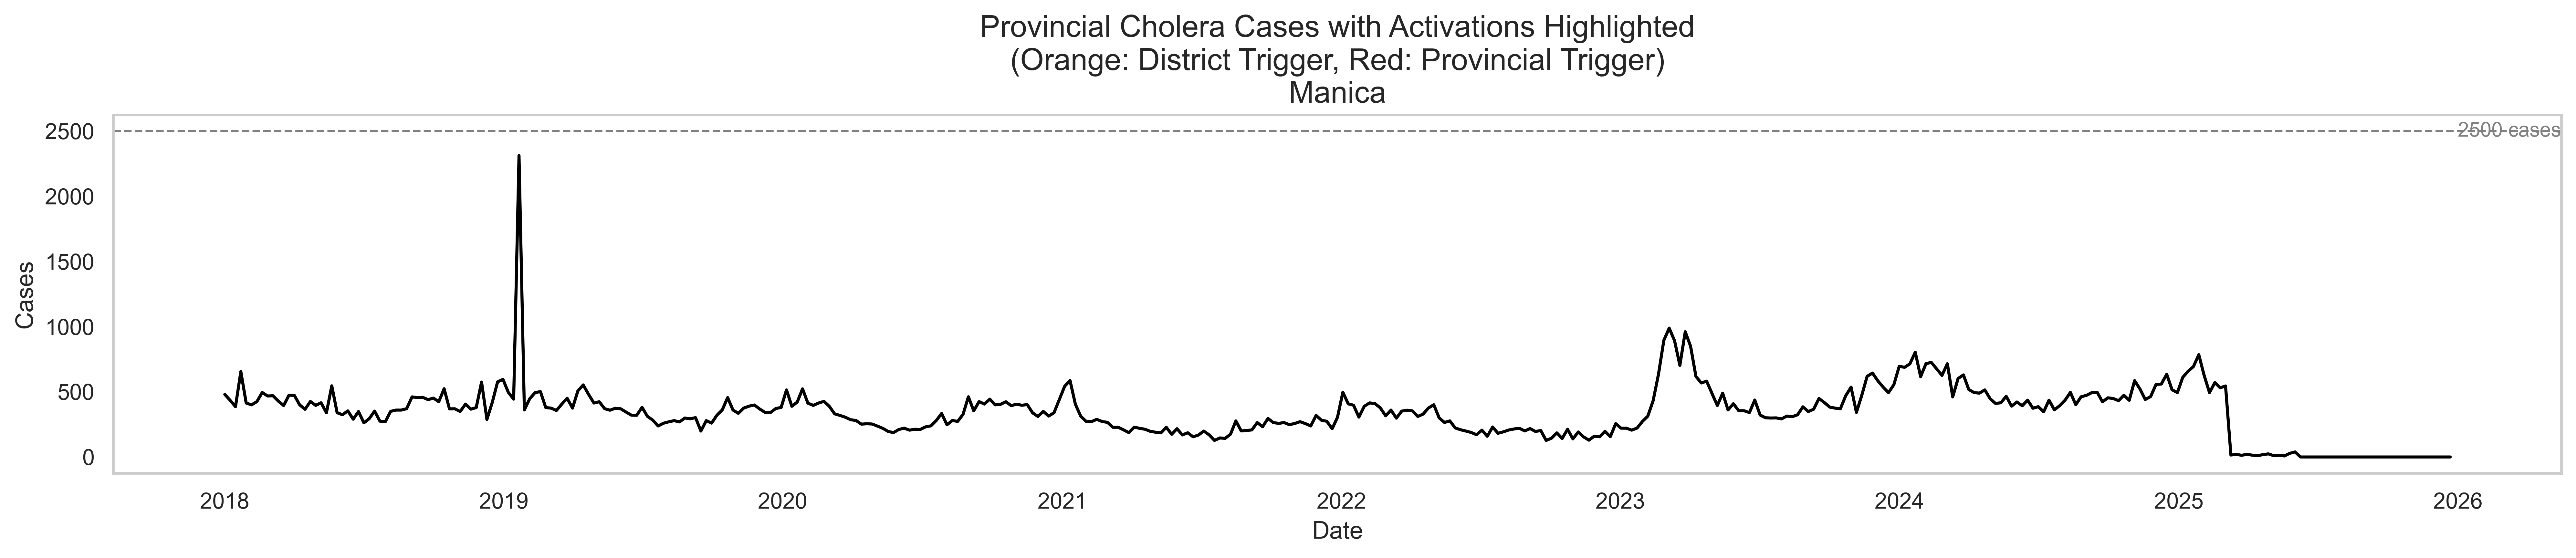

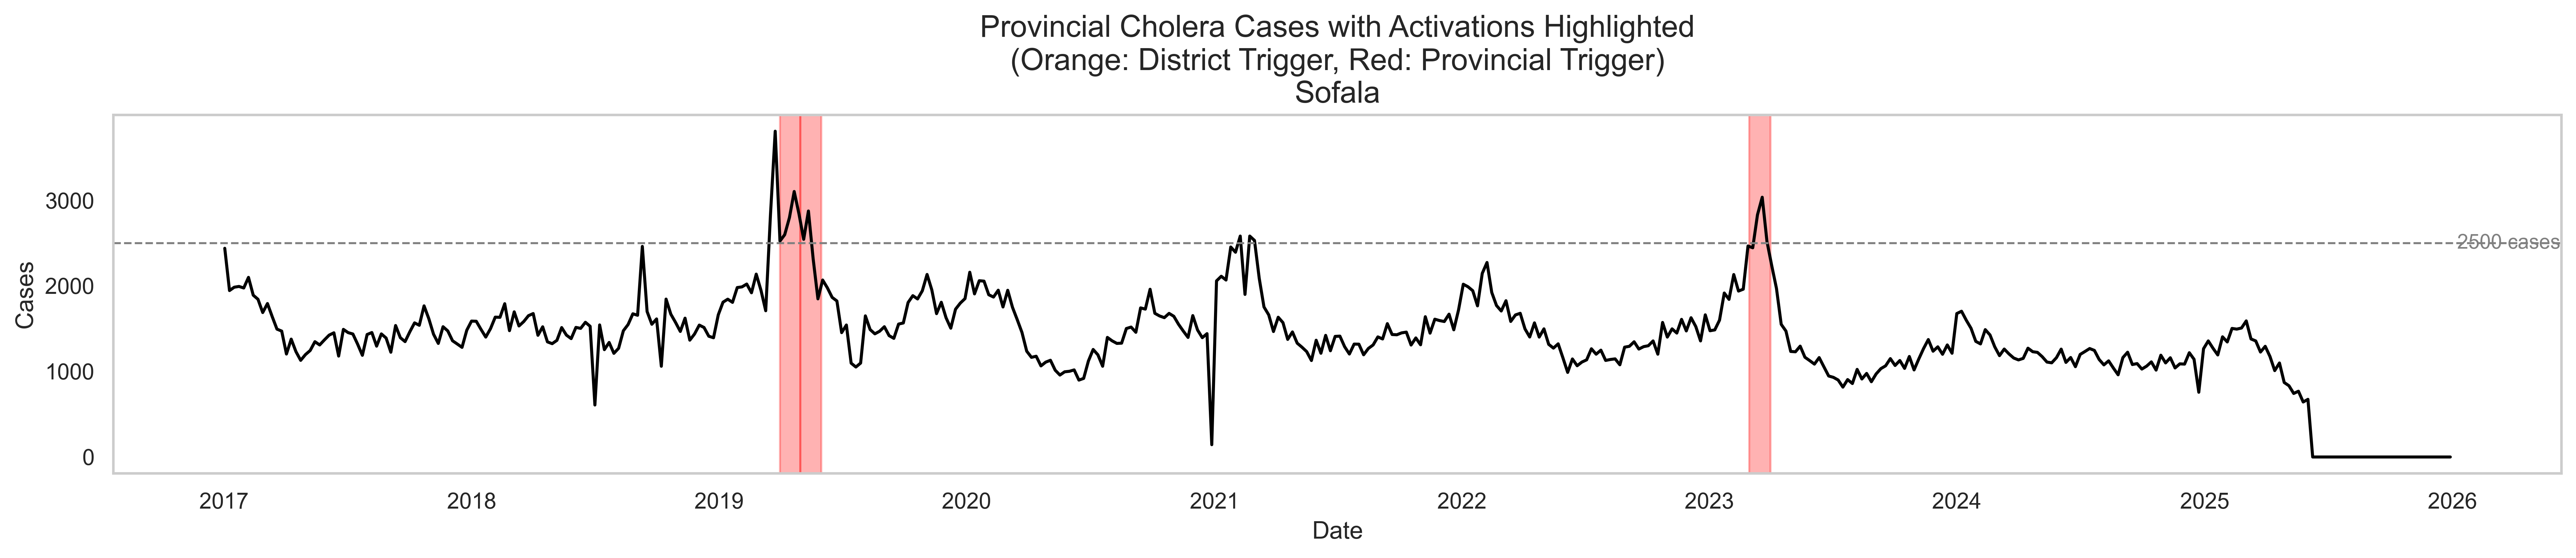

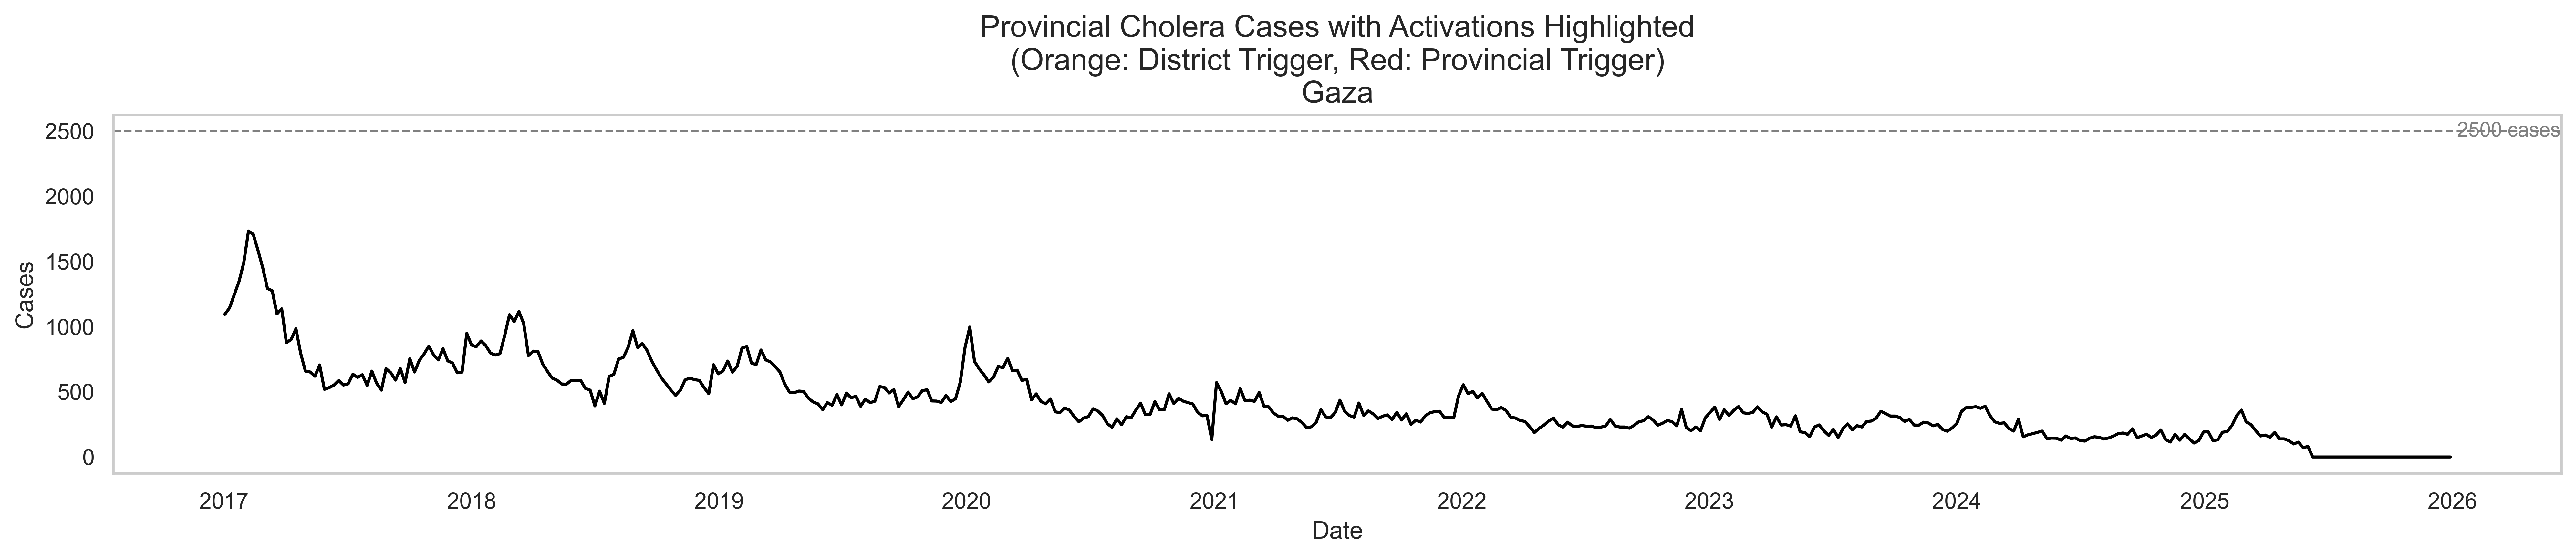

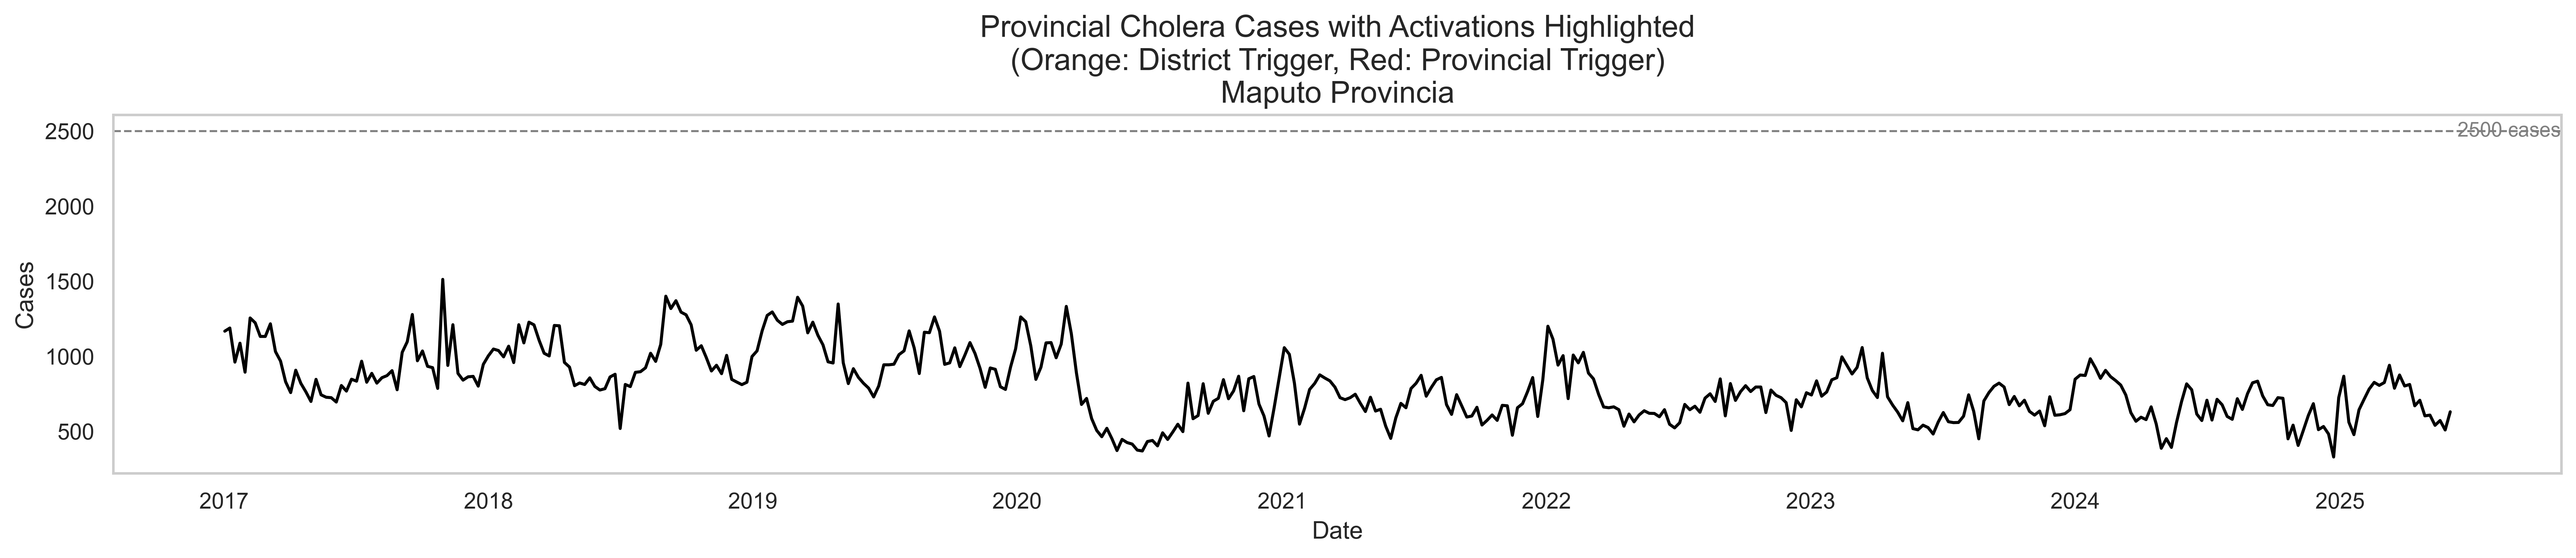

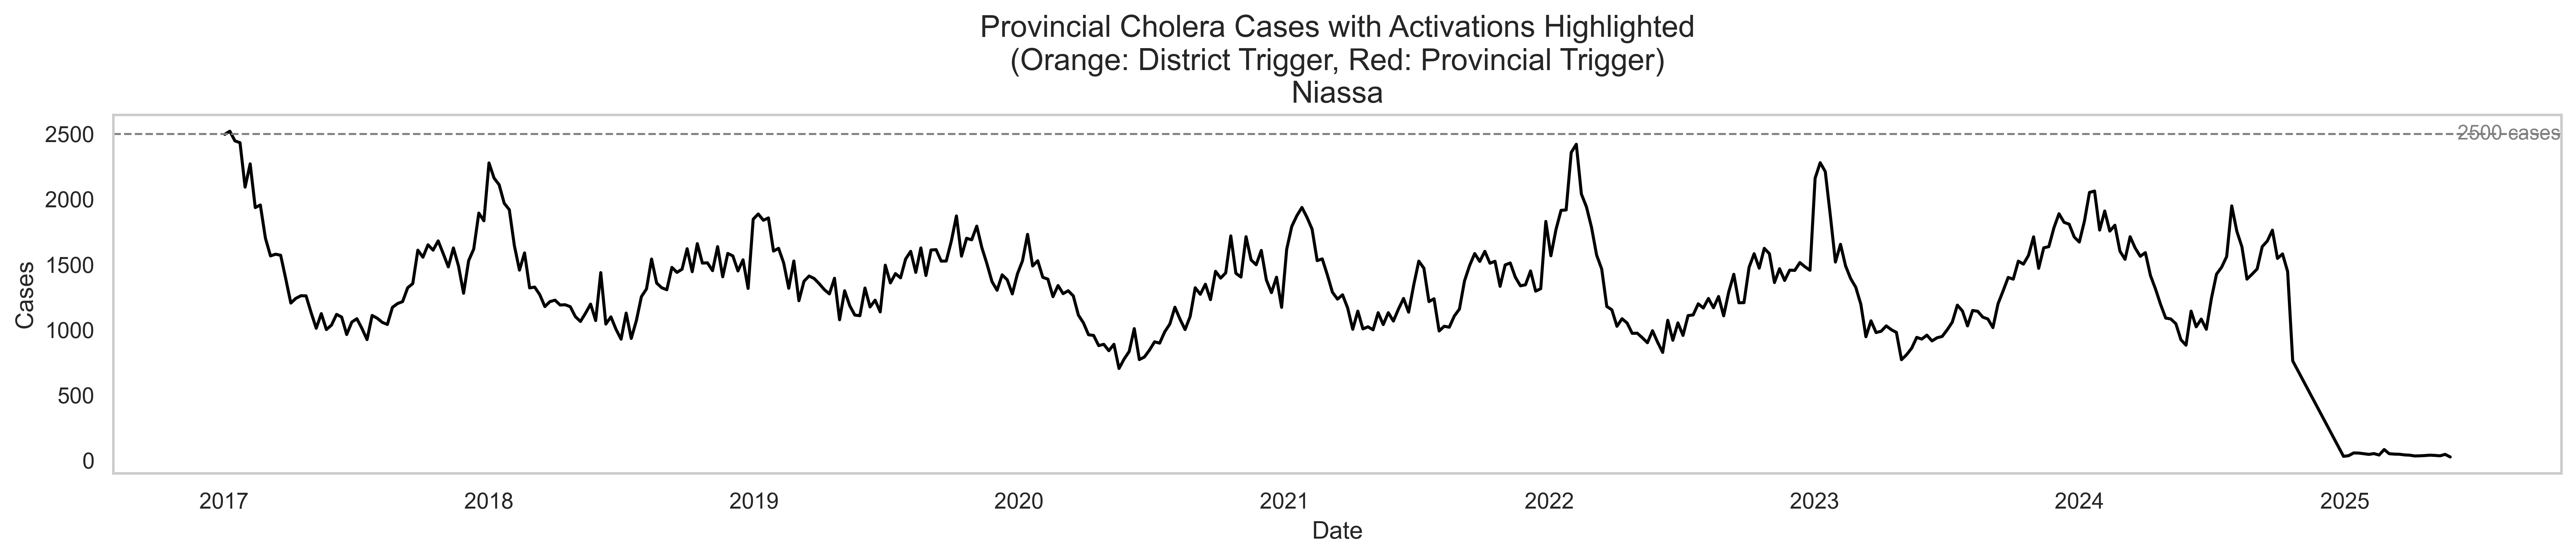

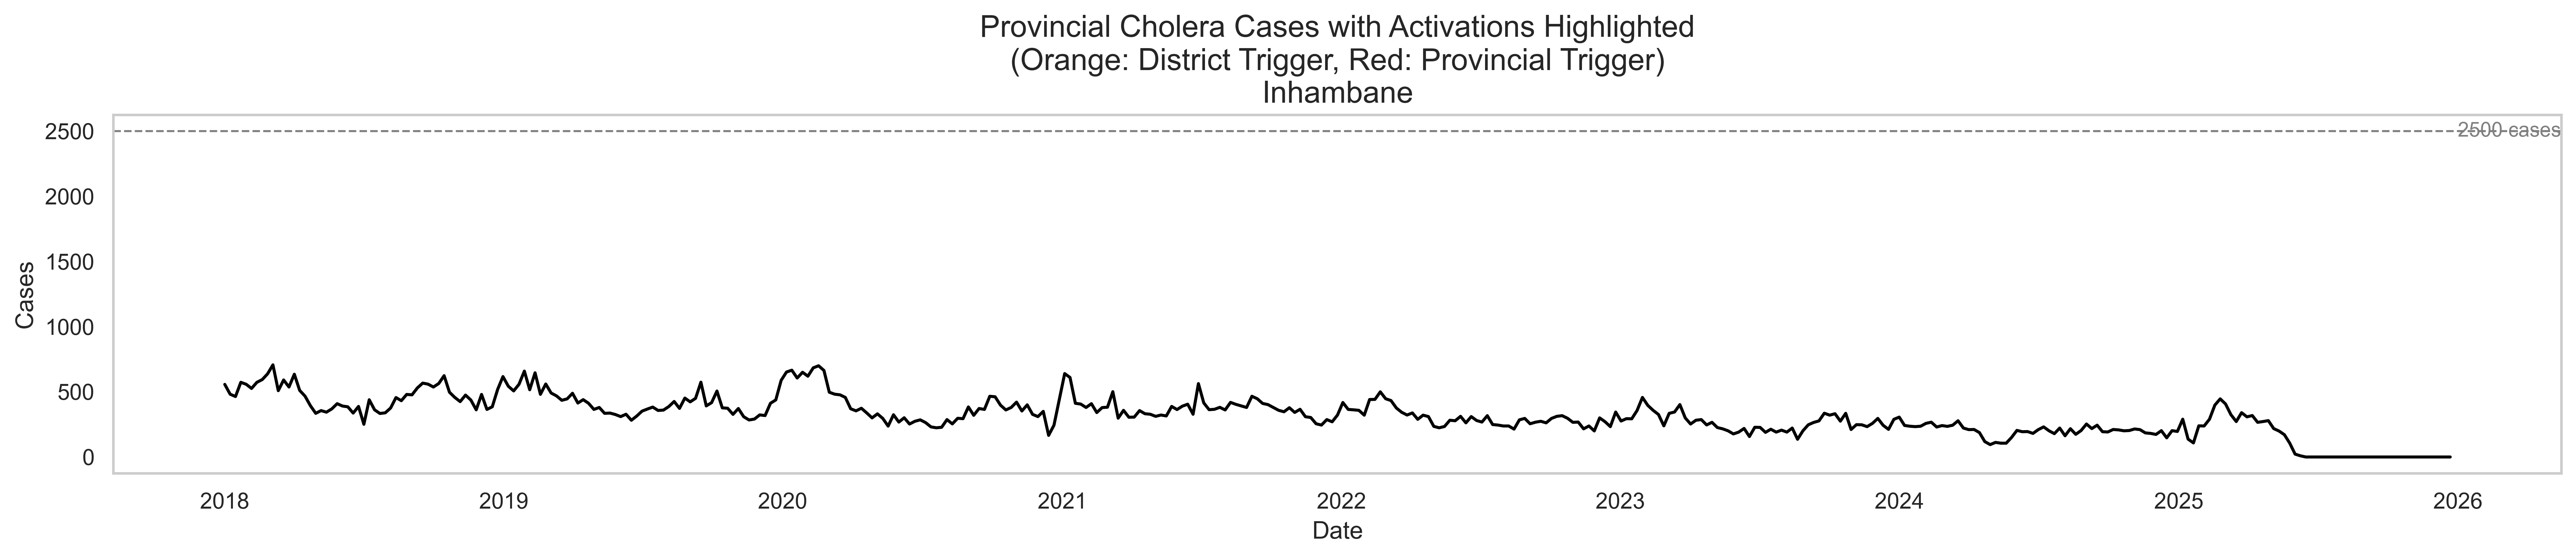

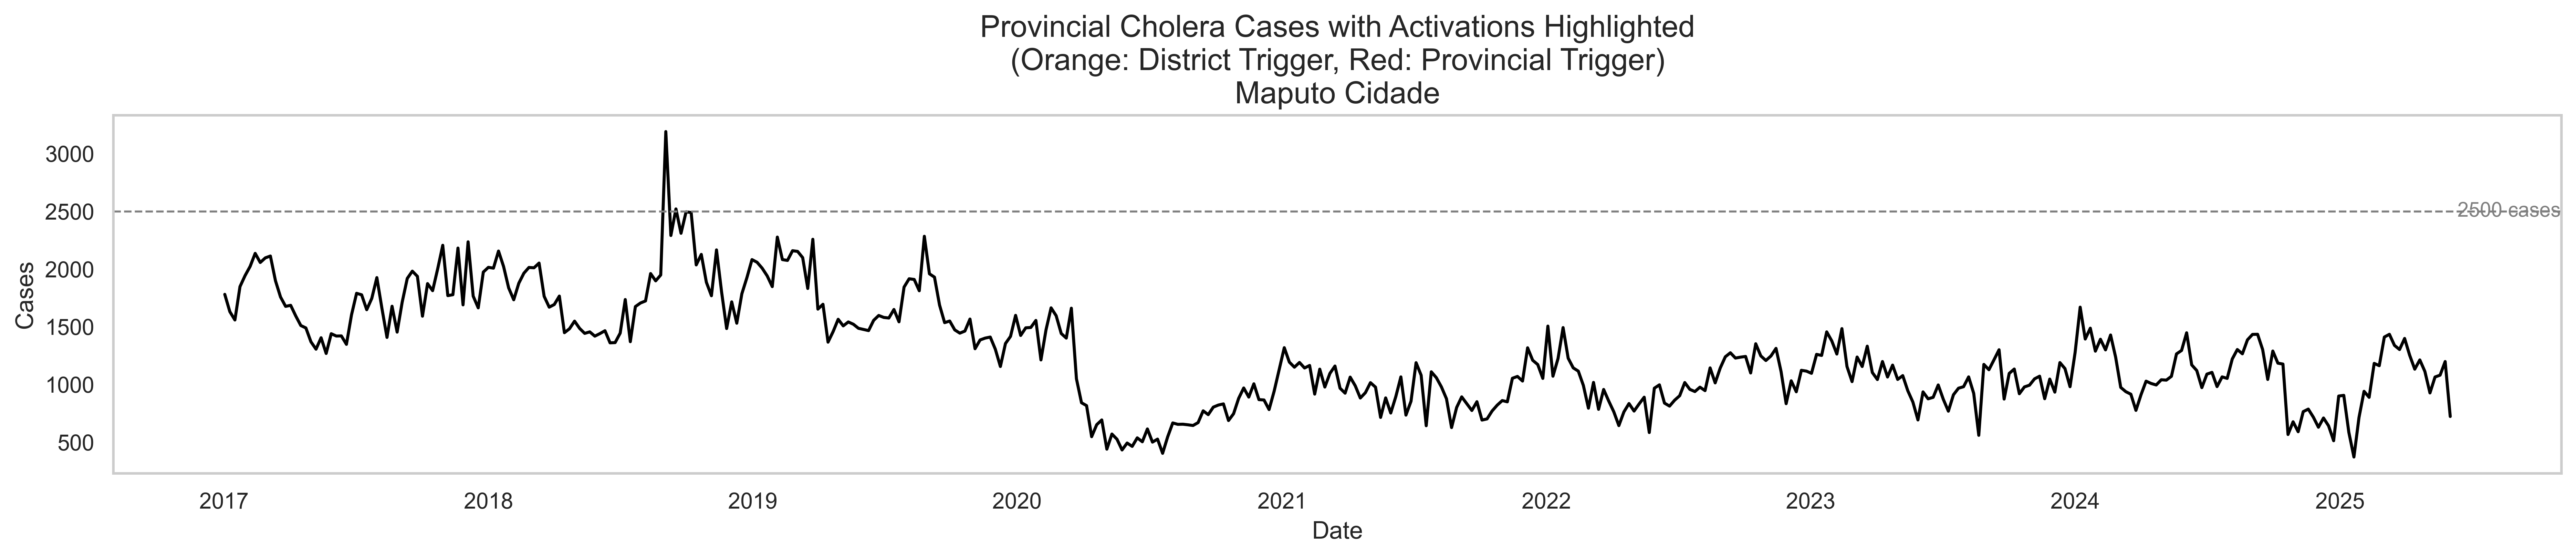

In [48]:
# Keep only provinces that have data
provinces = [
    p
    for p in district_df_with_percentiles["province"].dropna().unique()
    if not district_df_with_percentiles.loc[
        district_df_with_percentiles["province"] == p
    ].empty
]

for province in provinces:
    province_df = district_df_with_percentiles[
        district_df_with_percentiles["province"] == province
    ]

    # --- Aggregate totals per date ---
    agg = (
        province_df.groupby("date", as_index=False)
        .agg({"cases": "sum", "cases_per_100k": "sum"})
        .sort_values("date")
    )

    # --- District trigger (orange) ---
    trig_d = province_df.loc[
        province_df["district_consec_crossing"], ["date", "district"]
    ].copy()

    # Convert to week periods
    trig_d["week_period"] = pd.to_datetime(trig_d["date"]).dt.to_period("W")

    if trig_d.empty:
        weeks_district = set()
    else:
        # Count how many distinct districts triggered per week
        per_week_n = trig_d.groupby("week_period")["district"].nunique()

        # keep only weeks where more than 1 district triggered
        weeks_district = set(per_week_n.loc[per_week_n > 1].index)

    # --- Provincial trigger (red) ---
    trig_p = province_df.loc[
        province_df["adm1_threshold_crossed"], ["date"]
    ].copy()
    trig_p["month_period"] = pd.to_datetime(trig_p["date"]).dt.to_period("M")
    months_provincial = set(trig_p["month_period"].unique())

    # --- Add period columns ---
    agg["week_period"] = pd.to_datetime(agg["date"]).dt.to_period("W")
    agg["month_period"] = pd.to_datetime(agg["date"]).dt.to_period("M")
    agg["district_trigger"] = agg["week_period"].isin(weeks_district)
    agg["provincial_trigger"] = agg["month_period"].isin(months_provincial)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(18, 4), dpi=450)

    ax.plot(agg["date"], agg["cases"], linewidth=1.5, color="black")

    # Shade district weeks (orange)
    for wp in weeks_district:
        start = wp.start_time
        end = wp.end_time
        ax.axvspan(start, end, color="orange", alpha=0.3)

    # Shade provincial months (red)
    for mp in months_provincial:
        start = mp.to_timestamp()
        end = (mp + 1).to_timestamp()
        ax.axvspan(start, end, color="red", alpha=0.3)

    # --- Horizontal line and label ---
    y_thresh = province_case_limit
    ax.axhline(y_thresh, color="gray", linestyle="--", linewidth=1)
    ax.text(
        agg["date"].max() + pd.Timedelta(days=10),
        y_thresh,
        "2500 cases",
        va="center",
        ha="left",
        fontsize=10,
        color="gray",
    )

    # --- Titles and labels ---
    ax.set_title(
        f"Provincial Cholera Cases with Activations Highlighted\n"
        f"(Orange: District Trigger, Red: Provincial Trigger)\n{province}",
        fontsize=15,
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Cases")
    ax.tick_params(axis="x", rotation=0)
    ax.grid(False)

    plt.tight_layout()
    plt.show()